In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from chronos import Chronos2Pipeline

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
import os

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]

In [3]:
folders = ['images', 'results']

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Folder already exists: images
Folder already exists: results


## Data Quality

In [4]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


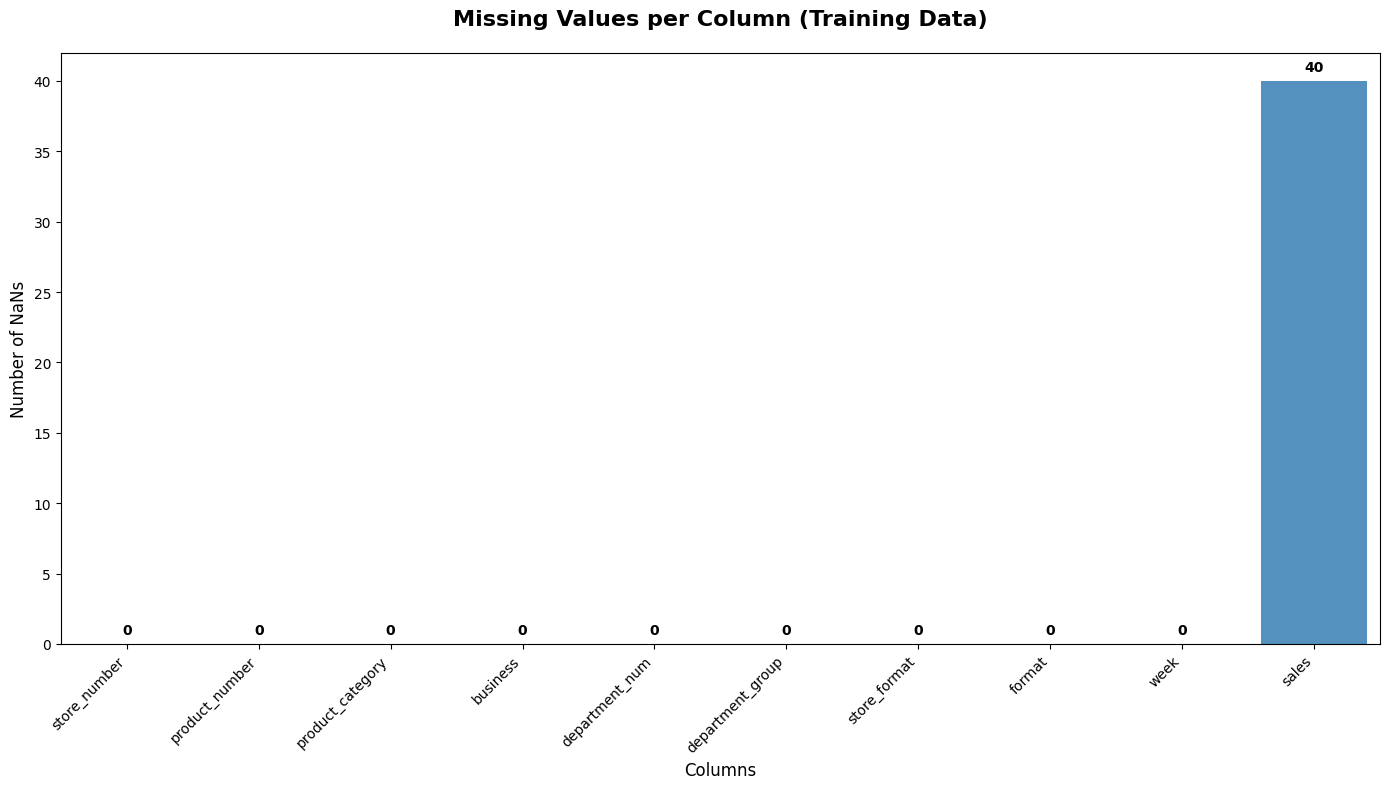

In [5]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(14, 8))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color="#4293D0")

plt.title("Missing Values per Column (Training Data)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/missing_values.png', dpi=300)
plt.show()

## Exploratory Data Analysis

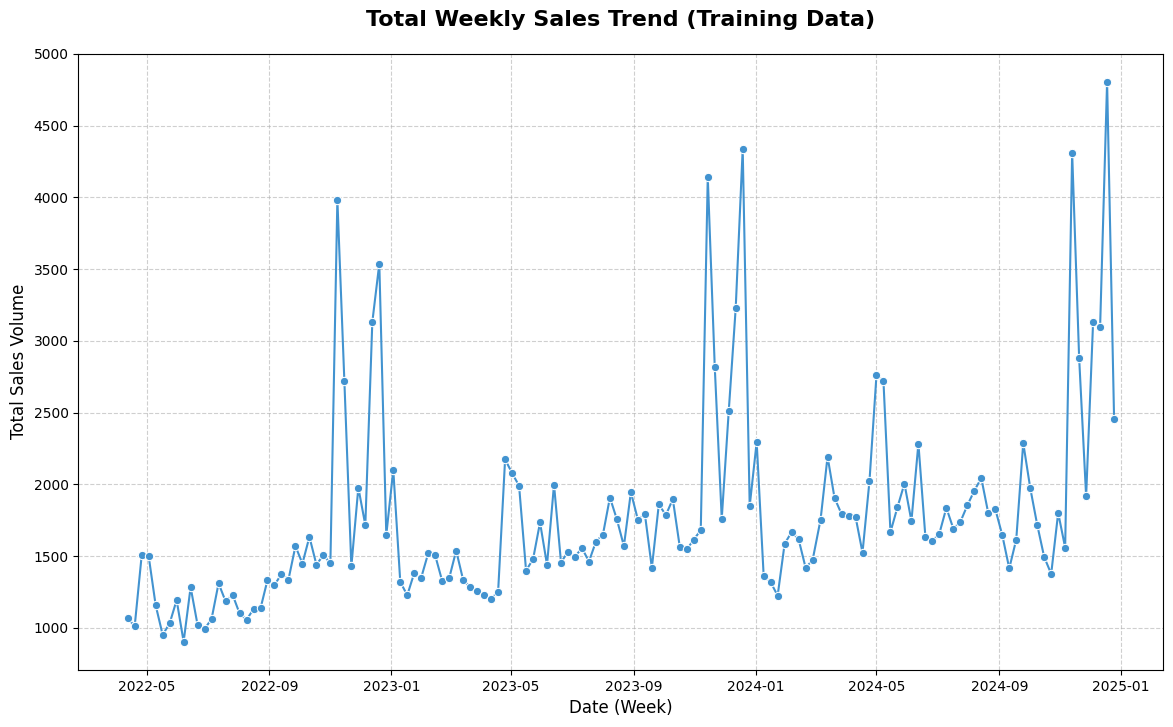

In [6]:
plt.figure(figsize=(14, 8))
weekly_sales = df_train.groupby('week')['sales'].sum().reset_index()
sns.lineplot(data=weekly_sales, x='week', y='sales', marker='o', color="#4293D0")
plt.title('Total Weekly Sales Trend (Training Data)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date (Week)', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('images/time_series.png', dpi=300)
plt.show()

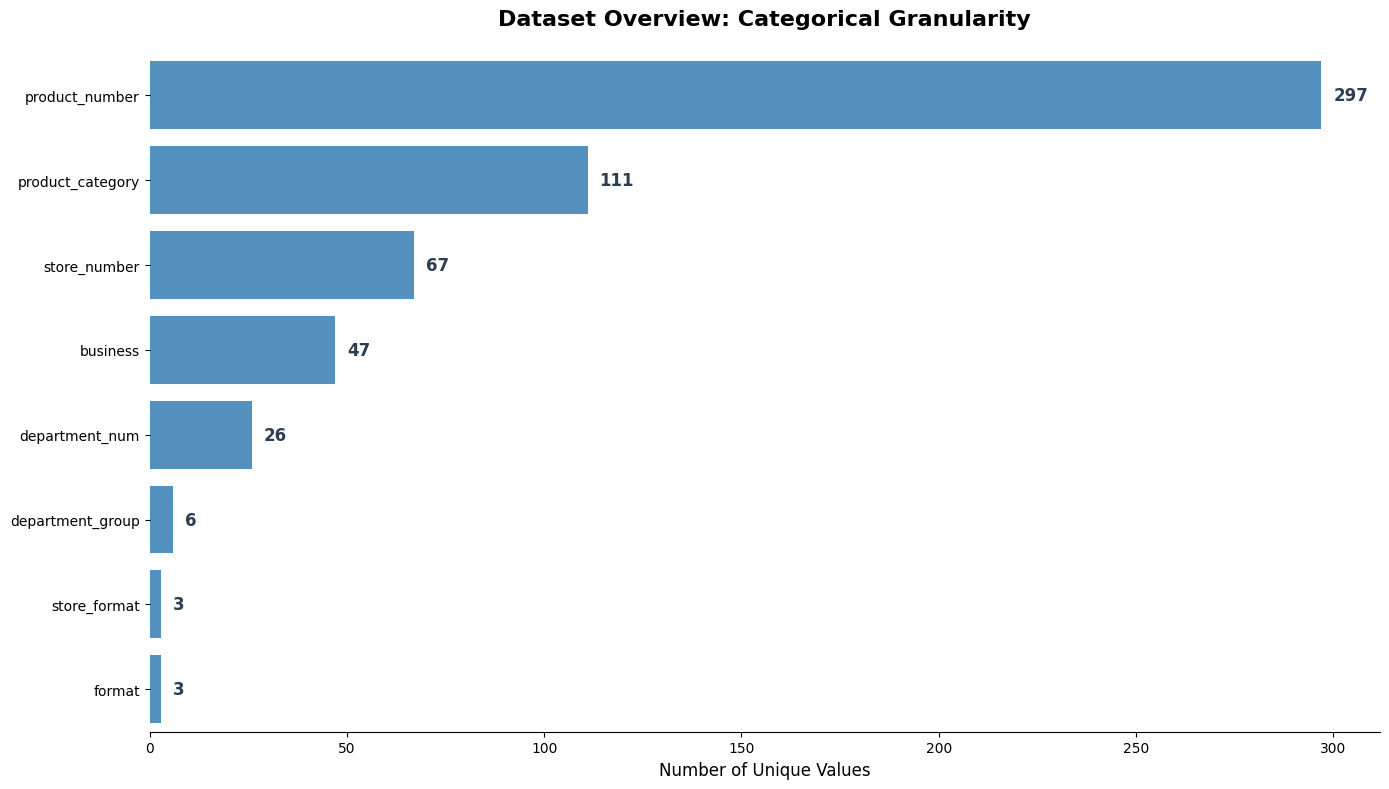

In [7]:
def display_dataset_summary_en(df):
    cols = [
        'product_number', 'product_category', 'business',
        'department_num', 'department_group', 'store_format', 'format', 'store_number'
    ]
    summary_data = [{'Dimension': col, 'Unique Count': df[col].nunique()} for col in cols]
    summary_df = pd.DataFrame(summary_data).sort_values('Unique Count', ascending=False)

    plt.figure(figsize=(14, 8))
    #sns.set_style("white") 
    
    target_blue = "#4293D0"

    ax = sns.barplot(
        x='Unique Count',
        y='Dimension',
        data=summary_df,
        color=target_blue
    )

    max_val = summary_df['Unique Count'].max()
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + (max_val * 0.01), 
                 p.get_y() + p.get_height()/2,
                 f'{int(width):,}', 
                 va='center', fontsize=12, fontweight='bold', color='#2c3e50')

    plt.title('Dataset Overview: Categorical Granularity', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Unique Values', fontsize=12)
    plt.ylabel('')
    
    sns.despine(left=True, bottom=False)

    plt.tight_layout()
    plt.savefig('images/unique_values_presentation.png', dpi=300)
    plt.show()

display_dataset_summary_en(df_train)

## Correlation store_format and format

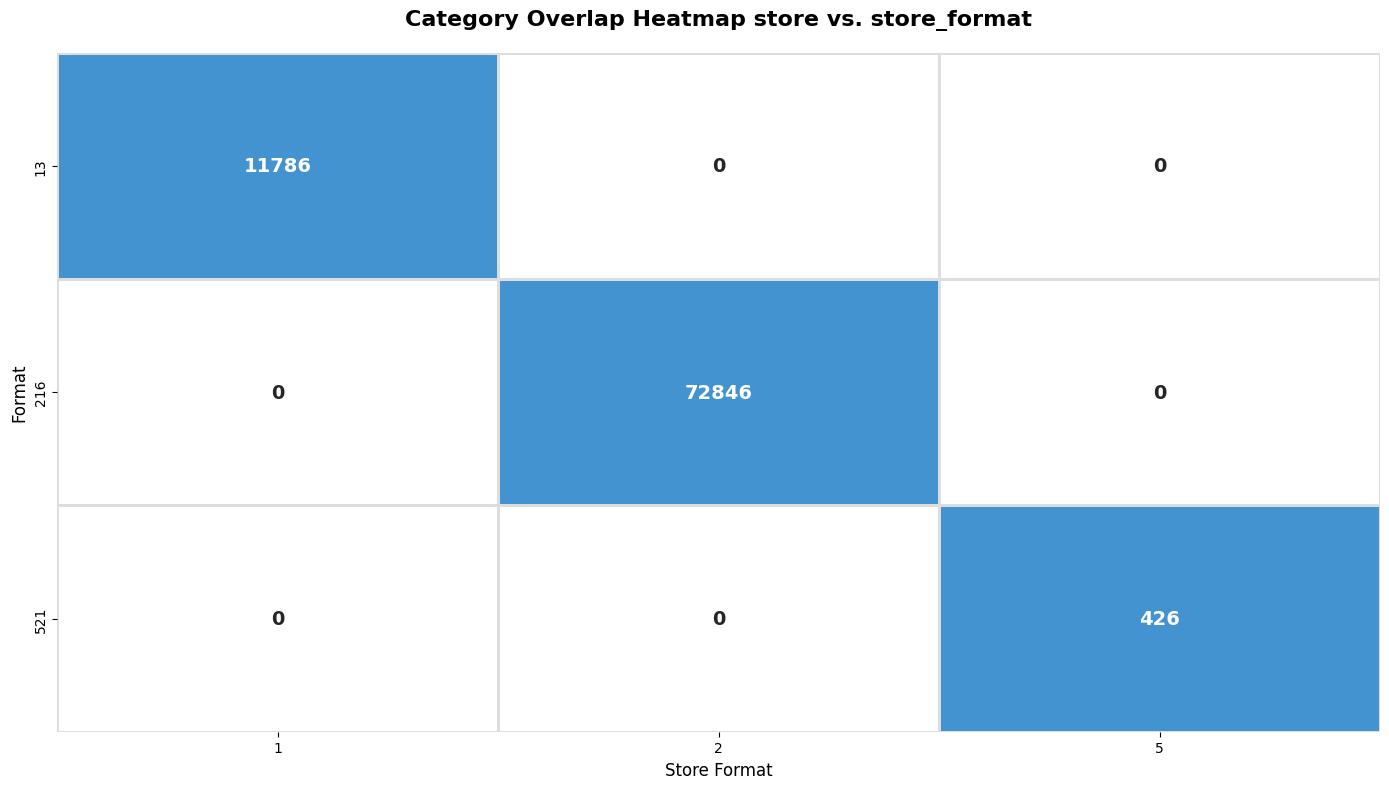

In [8]:
contingency_table = pd.crosstab(df_train['format'], df_train['store_format'])

target_blue = "#4293D0"
binary_cmap = ListedColormap(['#ffffff', target_blue])

plt.figure(figsize=(14, 8))

# Create the heatmap
sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap=binary_cmap, 
            vmin=0, 
            vmax=1, 
            cbar=False, 
            linewidths=1, 
            linecolor='#DDDDDD',
            # Set font size to 14 and keep it bold for visibility
            annot_kws={"size": 14, "weight": "bold"})

# Spearman correlation
correlation_value = df_train['store_format'].astype('category').cat.codes.corr(
    df_train['format'].astype('category').cat.codes, method='spearman')

plt.title(f'Category Overlap Heatmap store vs. store_format', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Format', fontsize=12)

plt.tight_layout()
plt.savefig("images/correlation_format_store-format.png", dpi=300)
plt.show()

In [9]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int64
dtype: object

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_59257/67874065.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)


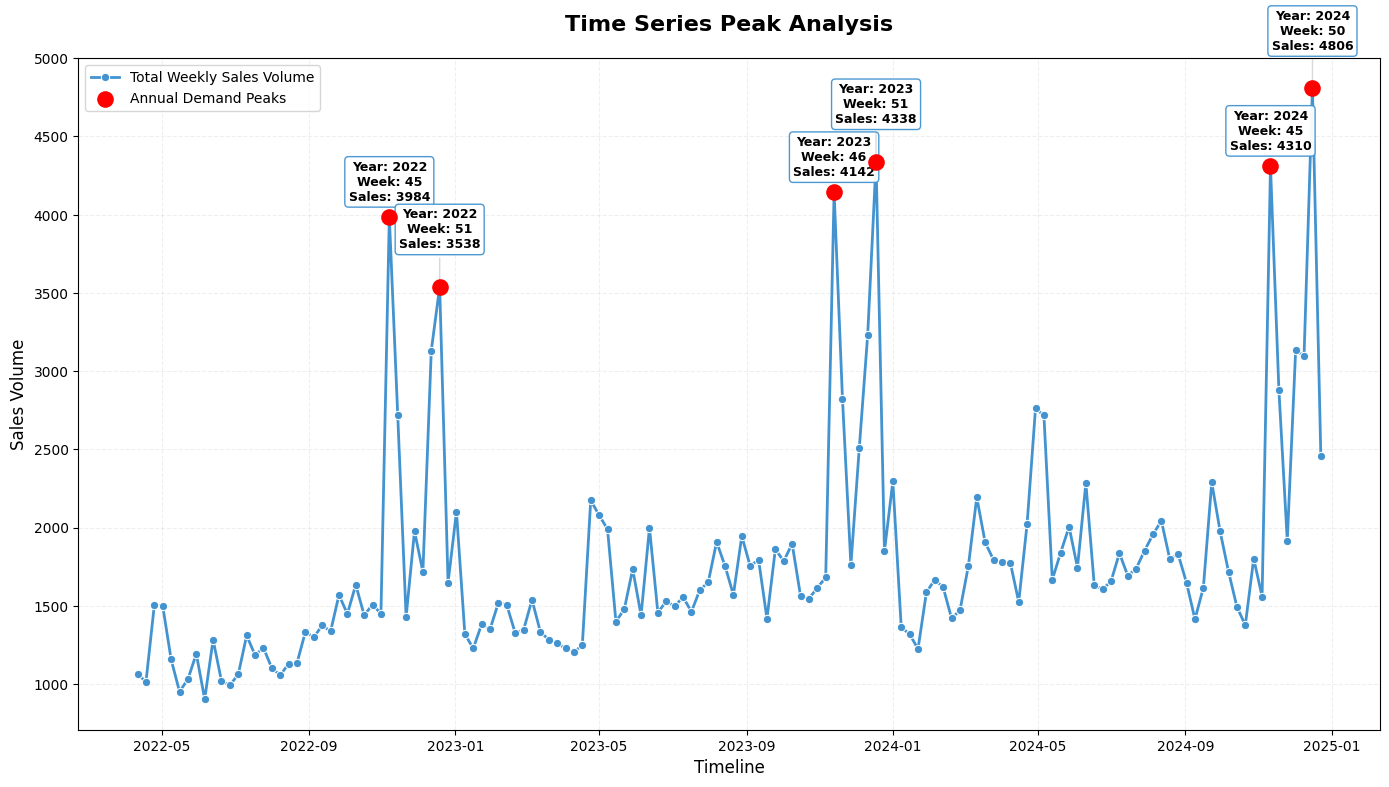

In [10]:
weekly_sales = X_train_preprocessed.groupby(['year', 'week'])['sales'].sum().reset_index()

peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)
peaks = peaks.sort_values('week')

target_blue = "#4293D0"

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=weekly_sales, 
    x='week', 
    y='sales', 
    marker='o', 
    color=target_blue, 
    linewidth=2, 
    label='Total Weekly Sales Volume'
)

plt.scatter(peaks['week'], peaks['sales'], color='red', s=120, zorder=5, label='Annual Demand Peaks')

for i, (_, row) in enumerate(peaks.iterrows()):
    week_num = row['week'].strftime('%U')
    
    # Smaller offsets to pull the boxes closer to the points
    y_offset = 12 if i % 2 == 0 else 28
    
    plt.annotate(
        f"Year: {int(row['year'])}\nWeek: {week_num}\nSales: {int(row['sales'])}",
        xy=(row['week'], row['sales']),
        xytext=(0, y_offset), 
        textcoords='offset points',
        ha='center',
        fontsize=9,
        fontweight='bold',
        # Subtle arrow to maintain the link without clutter
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3),
        # Professional thin-border box in your target blue
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=target_blue, lw=1, alpha=0.95)
    )

plt.title('Time Series Peak Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/final_time_series_2peaks.png', dpi=300)
plt.show()

## Store Variety

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_59257/894235783.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


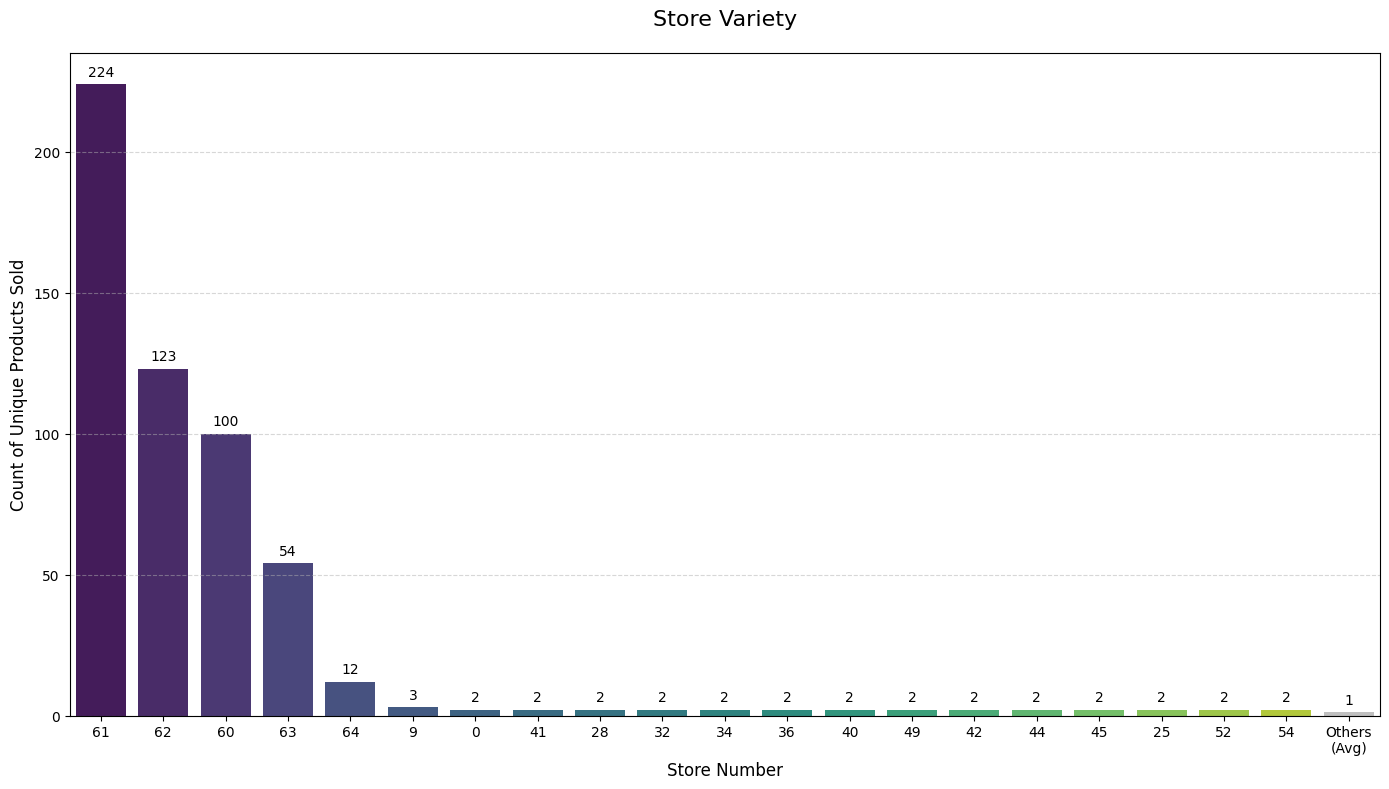

In [11]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others\n(Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16, pad=20)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
#plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.savefig('images/store_variety.png')
plt.show()

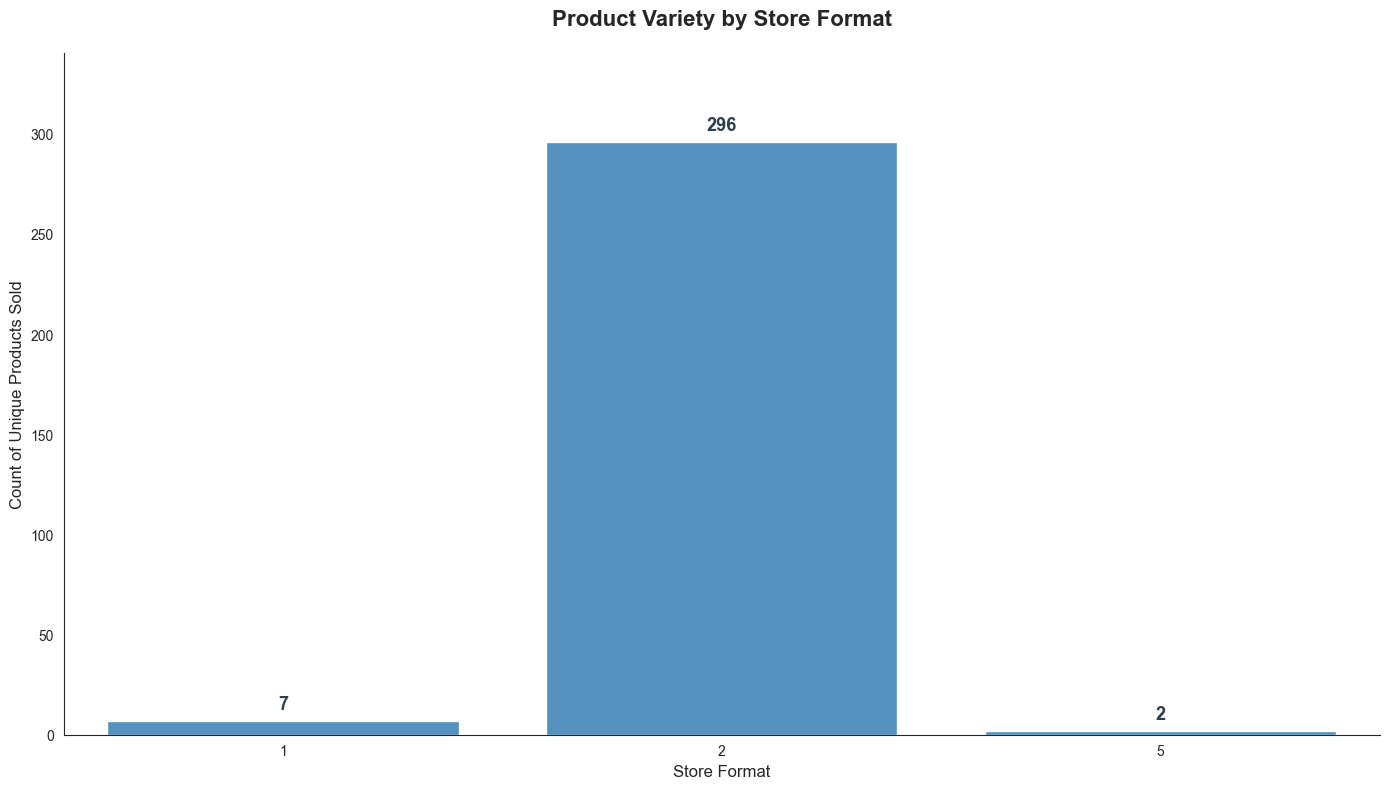

In [12]:
format_variety = (
    X_train_preprocessed[X_train_preprocessed['sales'] > 0]
    .groupby('store_format')['product_number']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
)
format_variety.columns = ['store_format', 'unique_products']

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=format_variety,
    x='store_format',
    y='unique_products',
    color=target_blue
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=13, fontweight='bold', color='#2c3e50')

plt.title('Product Variety by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xlabel('Store Format', fontsize=12)

plt.ylim(0, format_variety['unique_products'].max() * 1.15)

sns.despine()

plt.tight_layout()
plt.savefig('images/store_format_variety.png', dpi=300)
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_59257/1928865507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


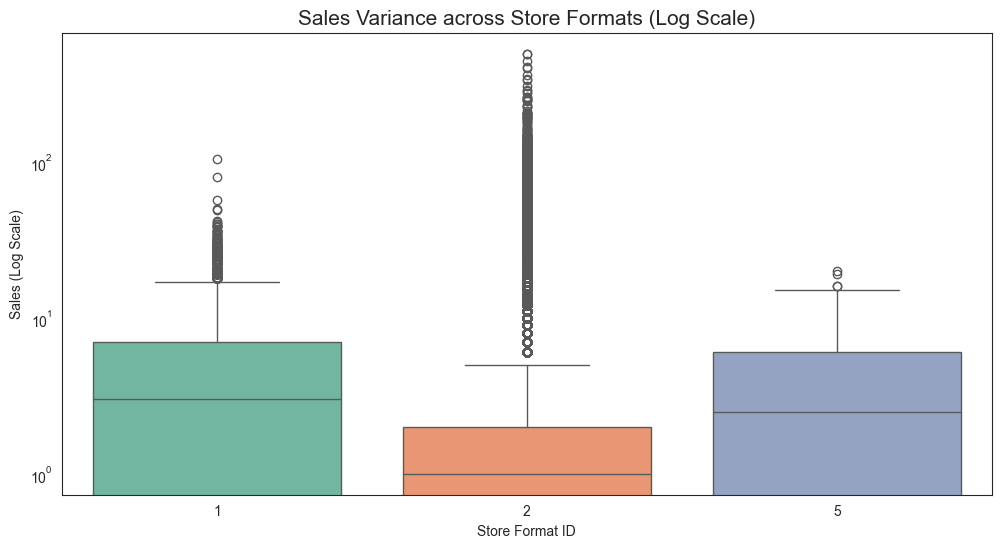

In [13]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.savefig('images/boxplot_store_format_variance.png')
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_59257/163496920.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


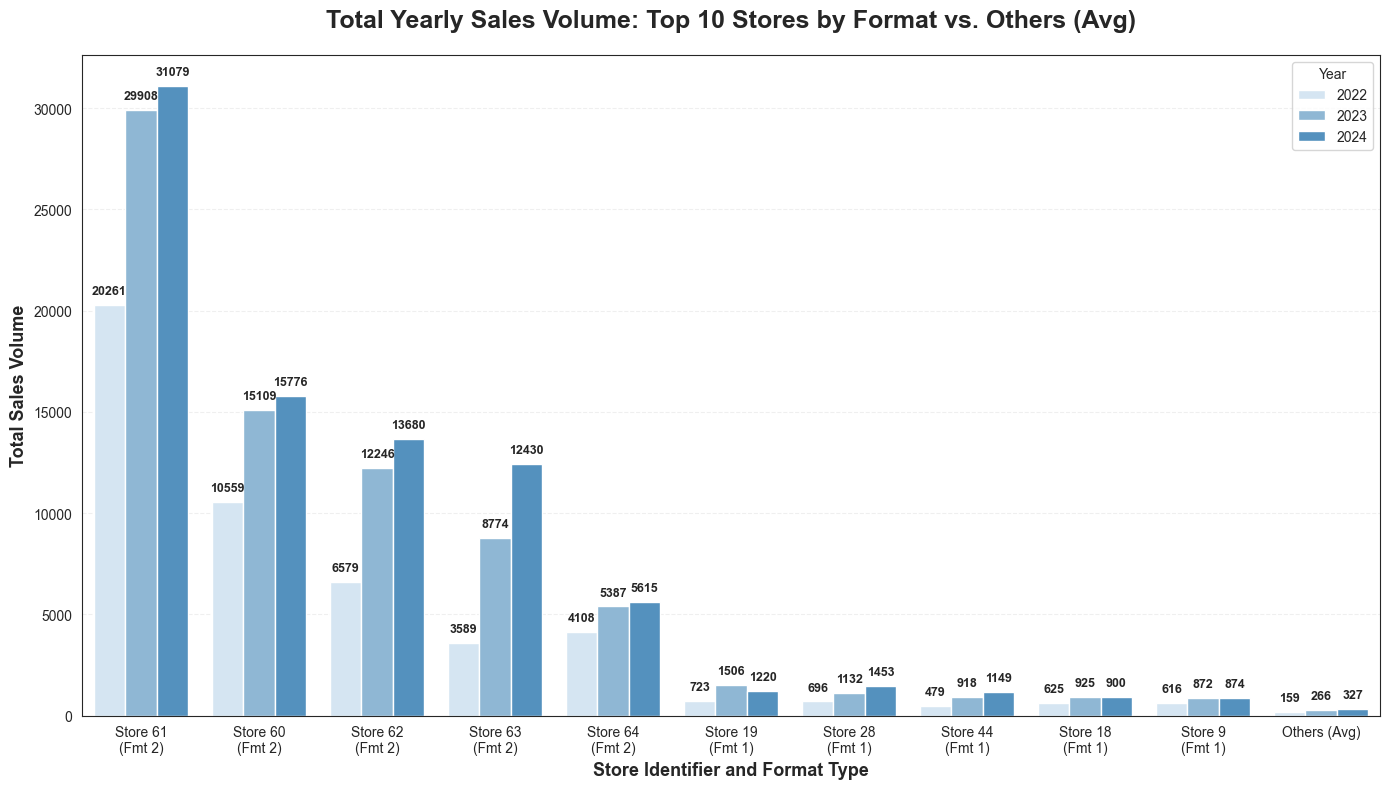

In [14]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()
store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

target_blue = "#4293D0"
num_years = plot_data['year'].nunique()
colors_list = ["#D0E6F7", "#84B9E0", target_blue]
custom_palette = LinearSegmentedColormap.from_list("custom_blues", colors_list)(np.linspace(0, 1, num_years))

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette=custom_palette, 
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Store Identifier and Format Type', fontsize=13, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=13, fontweight='bold')
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('images/yearly_sales_volume_stores.png')
plt.show()

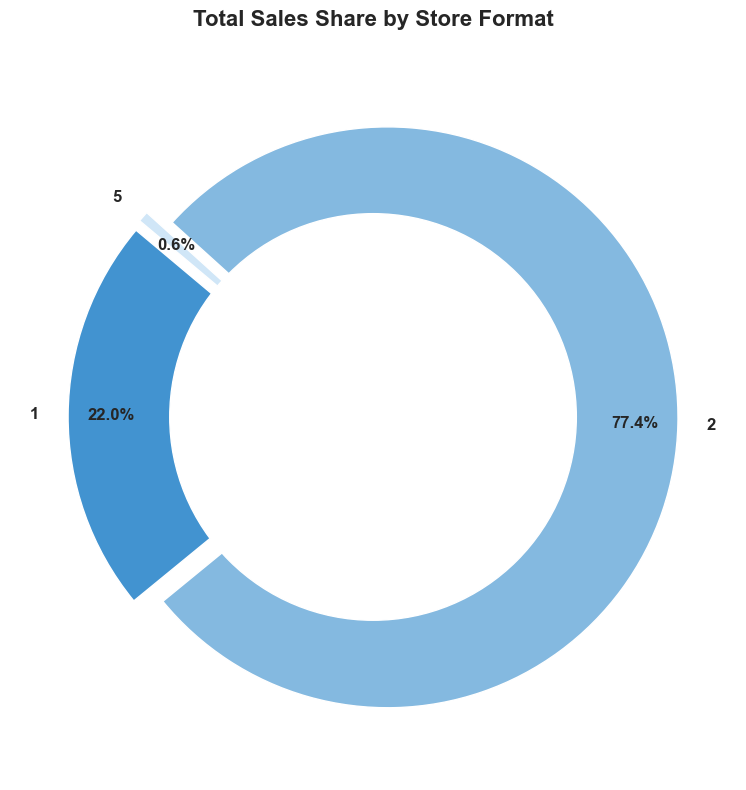

In [15]:
format_shares = X_train_preprocessed.groupby('store_format')['sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
target_blue = "#4293D0"

colors = [target_blue, "#84B9E0", "#D0E6F7"] 

# Pie Chart
plt.pie(
    format_shares['sales'], 
    labels=format_shares['store_format'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,
    explode=[0.05] * len(format_shares),
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Total Sales Share by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/sales_share_pie.png', dpi=300)
plt.show()

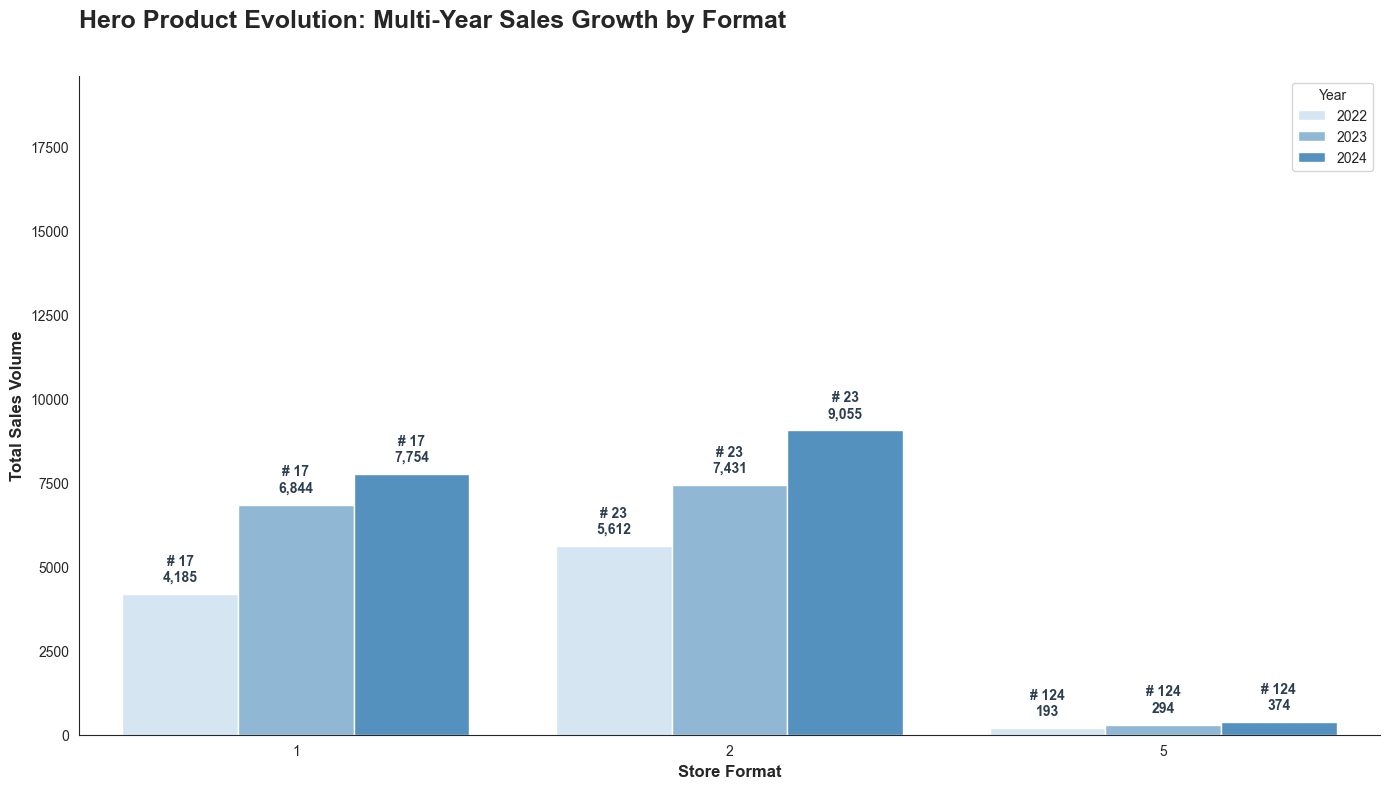

In [16]:
hero_skus = (
    X_train_preprocessed.groupby(['store_format', 'product_number'])['sales']
    .sum()
    .reset_index()
    .sort_values(['store_format', 'sales'], ascending=[True, False])
    .drop_duplicates('store_format')
)

top_sku_list = hero_skus['product_number'].unique()
plot_data = X_train_preprocessed[X_train_preprocessed['product_number'].isin(top_sku_list)].groupby(
    ['store_format', 'product_number', 'year']
)['sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=plot_data, 
    x='store_format', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        # Determine which format this bar belongs to
        num_formats = len(plot_data['store_format'].unique())
        fmt_idx = i % num_formats
        prod_num = hero_skus.iloc[fmt_idx]['product_number']
        
        plt.text(p.get_x() + p.get_width() / 2., 
                 height + (plot_data['sales'].max() * 0.02),
                 f'# {int(prod_num)}\n{int(height):,}', 
                 ha='center', va='bottom', 
                 fontsize=10, fontweight='bold', color='#2c3e50')

plt.title('Hero Product Evolution: Multi-Year Sales Growth by Format', 
          fontsize=18, fontweight='bold', pad=35, loc='left')
plt.xlabel('Store Format', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12, fontweight='bold')
plt.legend(title='Year', loc='upper right')

plt.ylim(0, plot_data['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()

plt.savefig('images/hero_products_per_format.png', dpi=300)
plt.show()

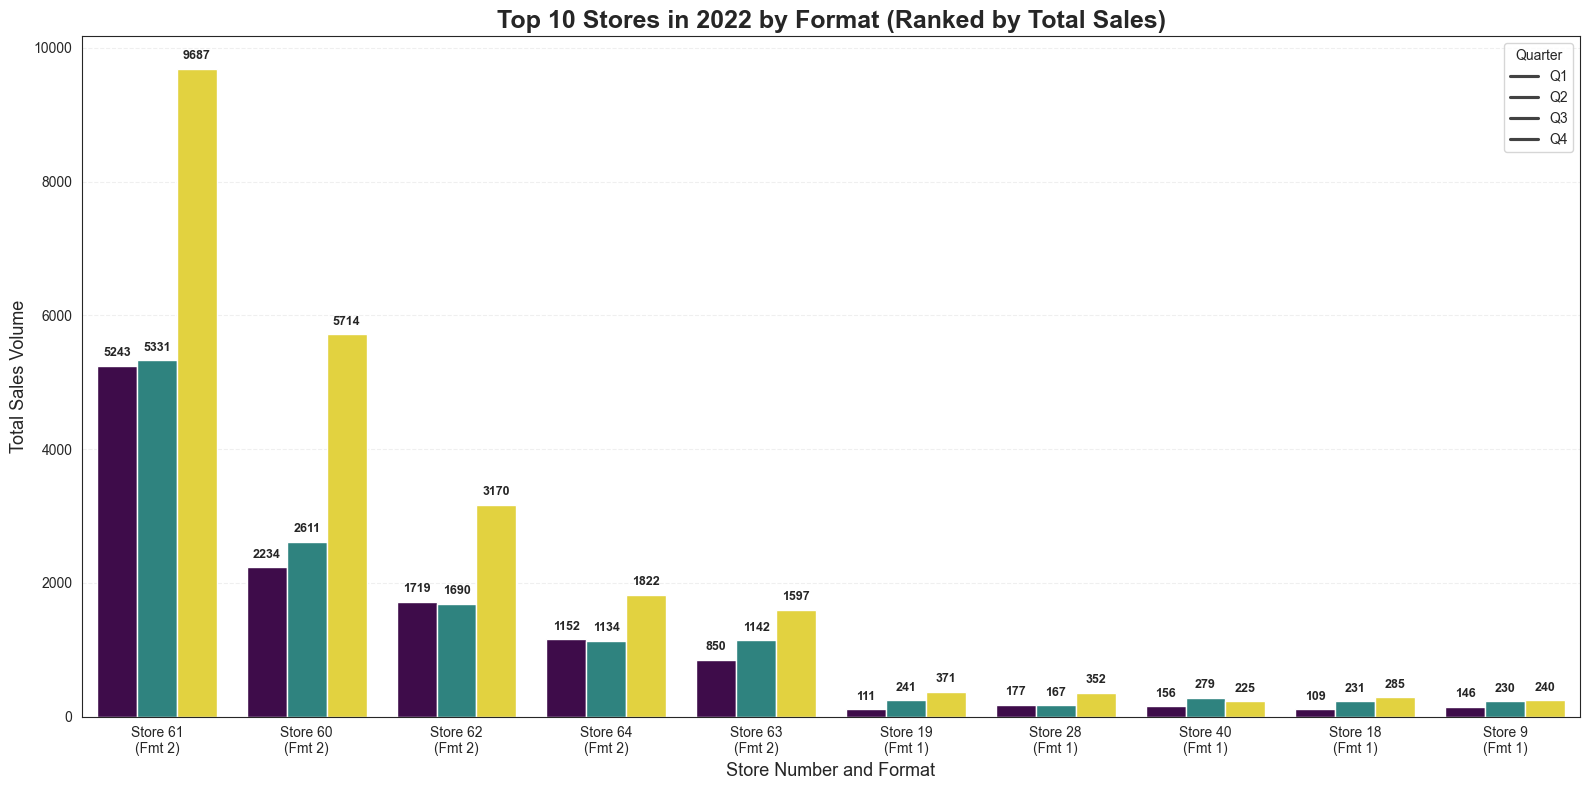

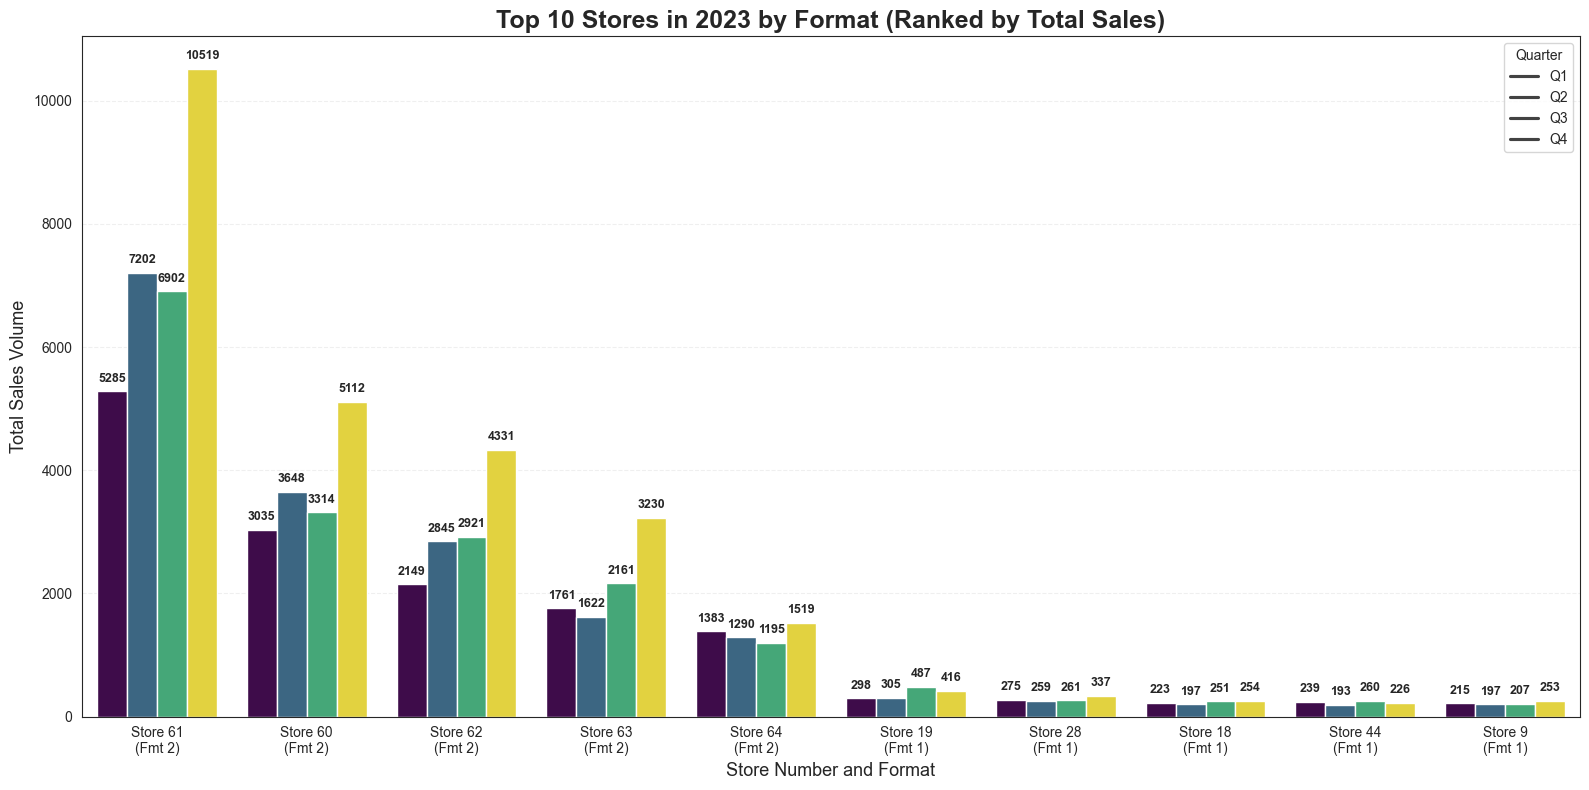

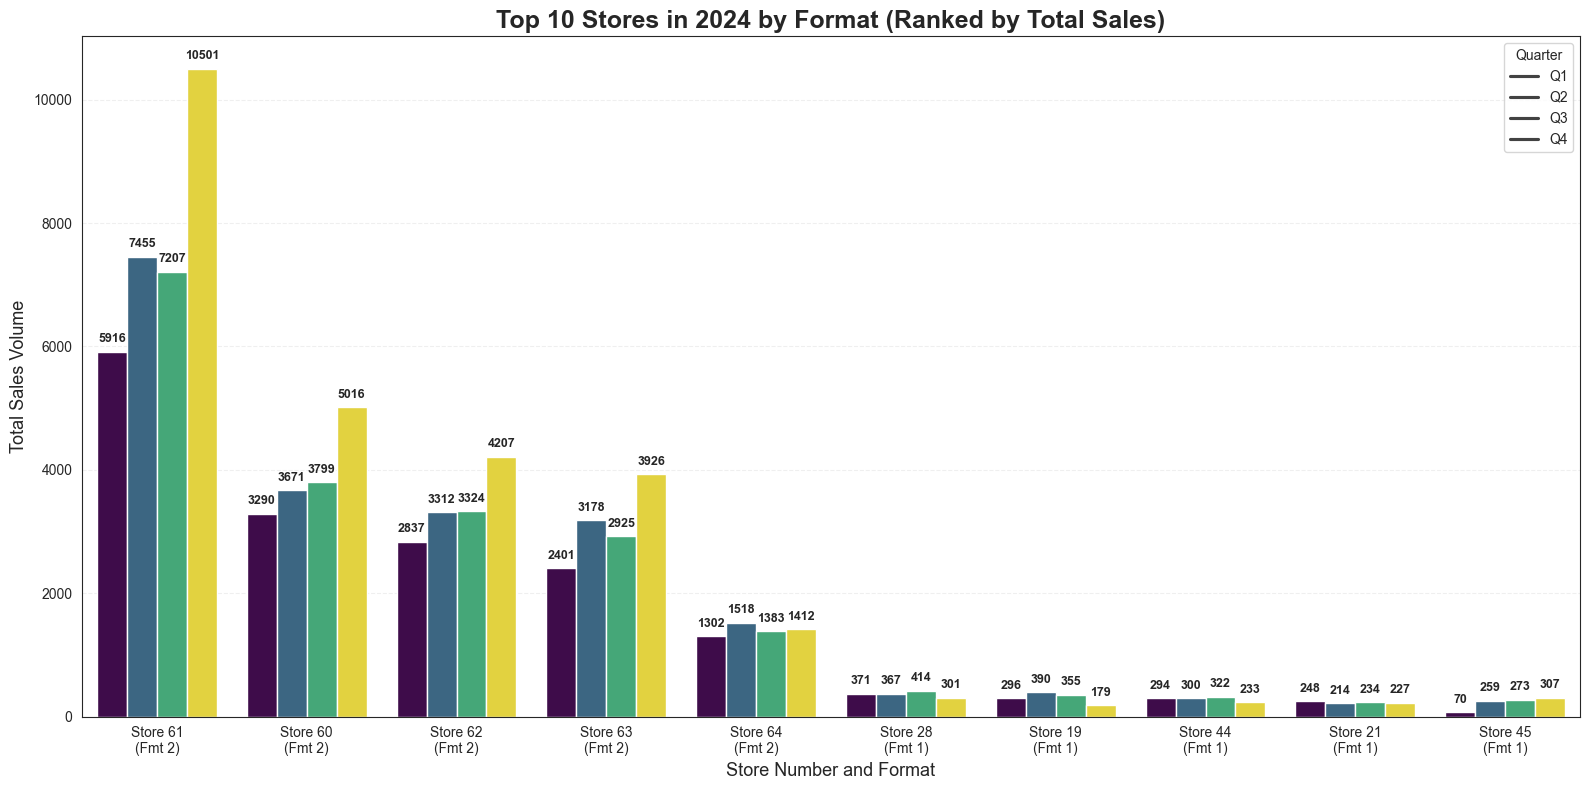

In [17]:
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

years = sorted(yearly_store_stats['year'].unique())

for year in years:
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    save_path = f'images/top_stores_{year}.png'
    plt.savefig(save_path)
    plt.show()

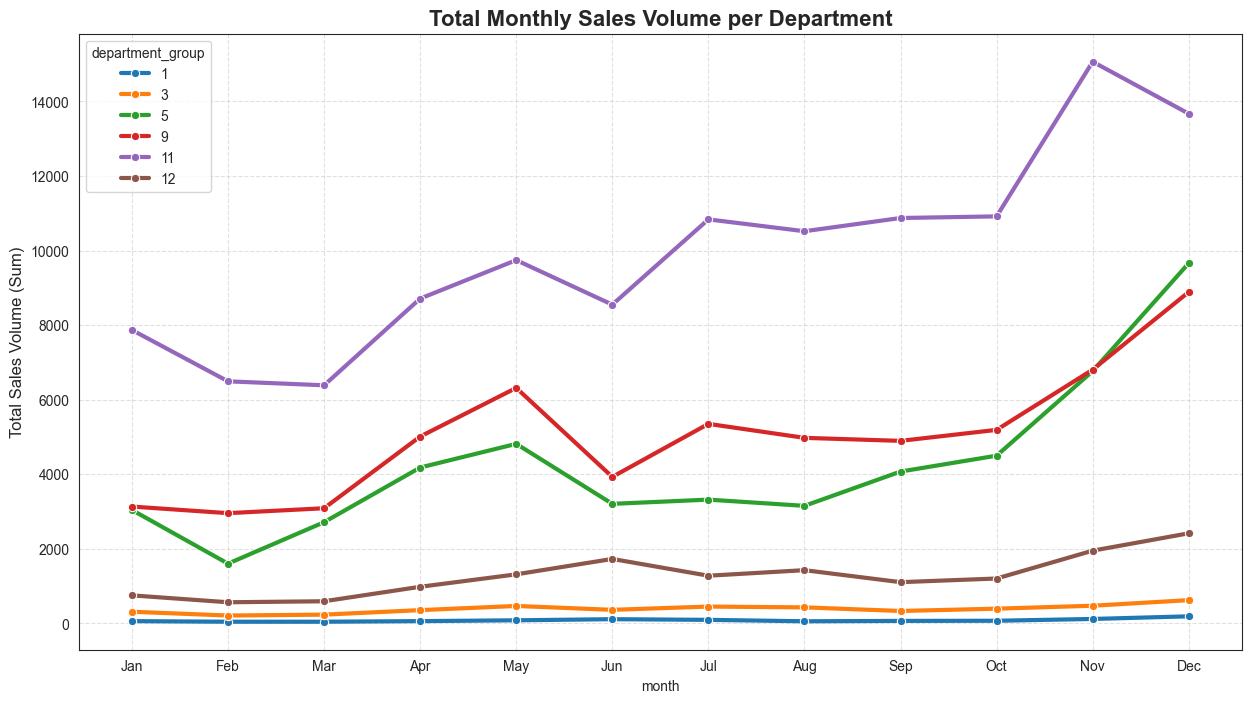

In [18]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("images/montly_sales_per_department.png")
plt.show()

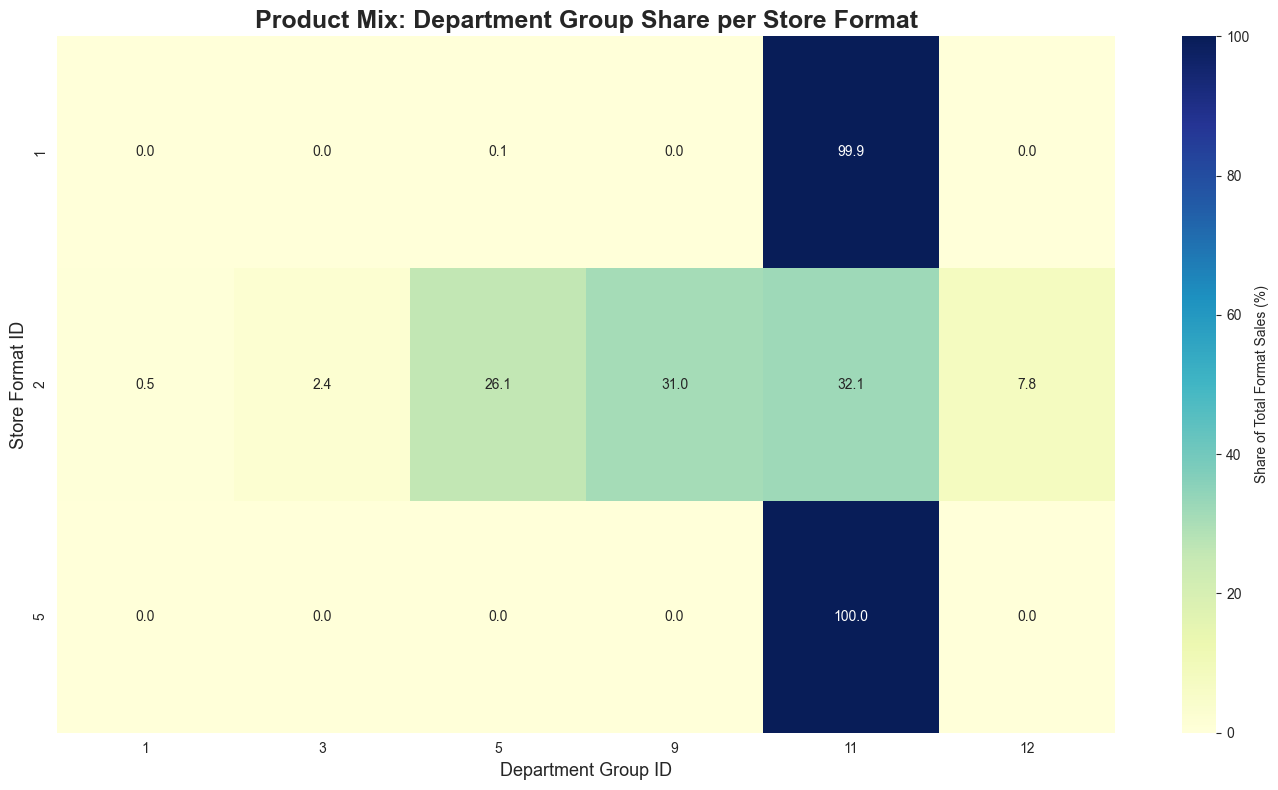

In [19]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.savefig("images/product_mix_per_store_format.png")
plt.show()

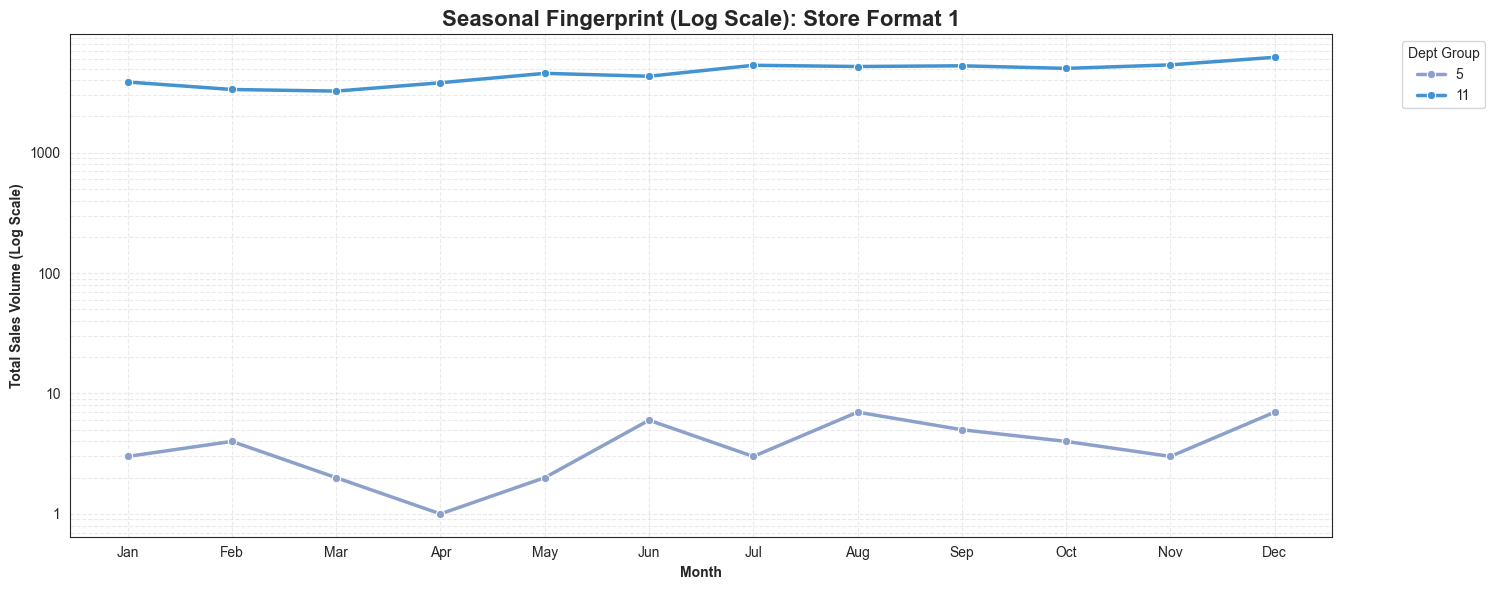

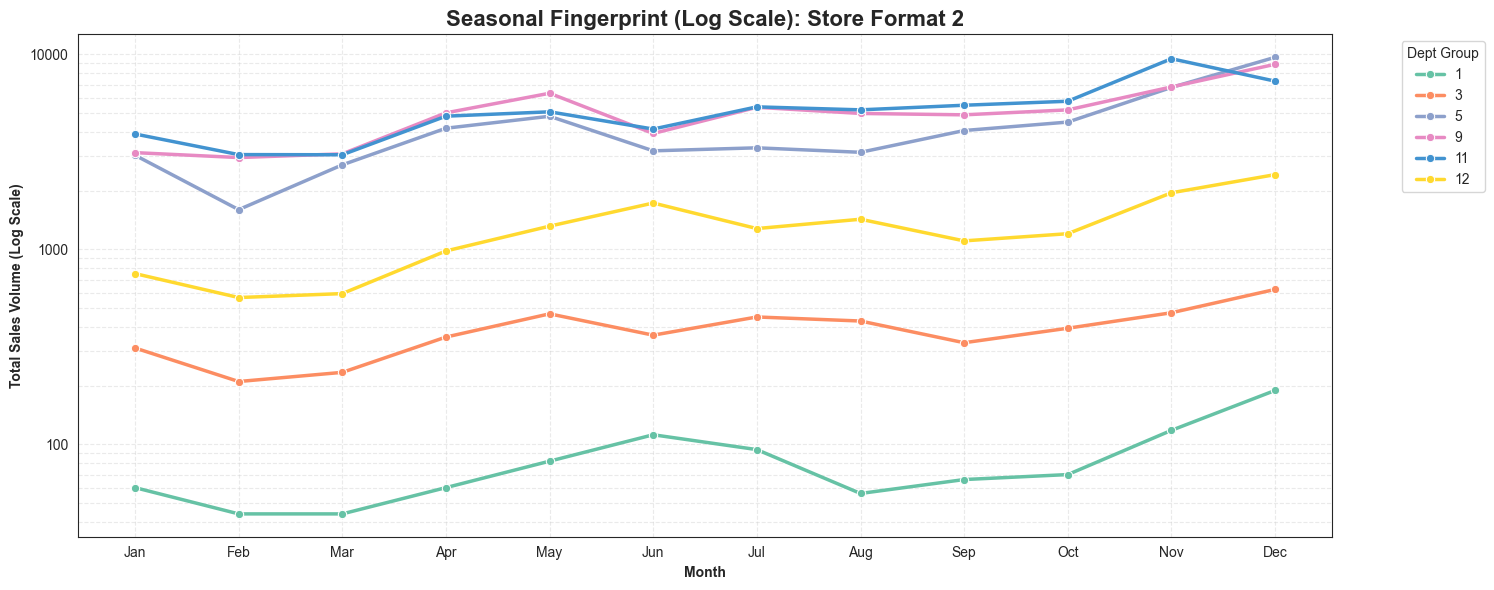

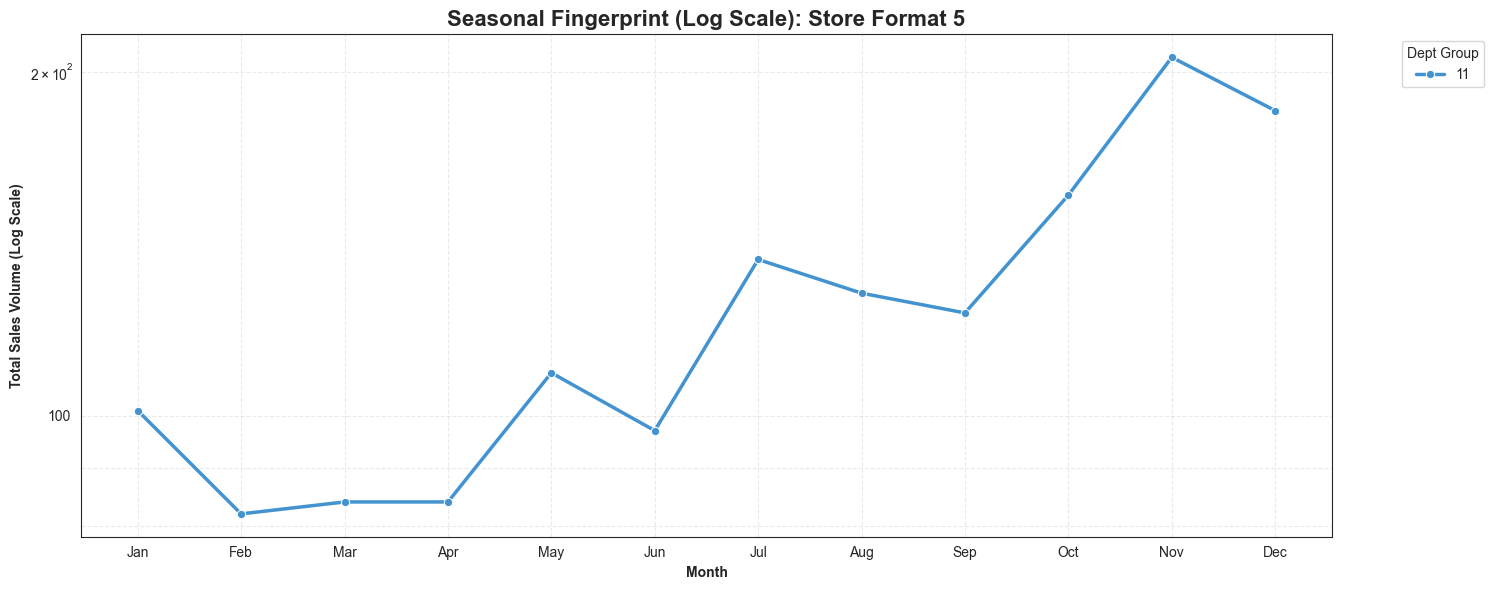

In [20]:
target_blue = "#4293D0"
all_depts = sorted(X_train_preprocessed['department_group'].unique())
base_colors = sns.color_palette("Set2", len(all_depts))
dept_color_map = {dept: base_colors[i] for i, dept in enumerate(all_depts)}

if 11 in dept_color_map:
    dept_color_map[11] = target_blue

unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    plt.figure(figsize=(15, 6))
    
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette=dept_color_map
    )

    plt.yscale('log')
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    plt.gca().yaxis.get_major_formatter().set_useOffset(False)

    plt.title(f'Seasonal Fingerprint (Log Scale): Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume (Log Scale)', fontweight='bold')
    plt.xlabel('Month', fontweight='bold')
    
    plt.grid(True, which="both", linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    save_path = f'images/seasonal_fingerprint_store_format_{fmt}_log.png'
    plt.savefig(save_path)
    plt.show()

## Feature Engineering

In [21]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,week,sales,month,...,rolling_std_4_wks,rolling_mean_12_wks,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,prod_store_share,perf_vs_store,yoy_growth
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,85058.000000,...,74276.000000,69484.000000,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,7.607300e+04,65151.000000,5.391000e+04
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,2023-08-17 11:59:59.999999744,2.964413,6.866197,...,1.737603,2.873261,0.956172,2.842173,2.705913,2.965433,0.002152,8.359471e+05,1.022792,6.902806e+05
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,2022-04-11 00:00:00,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000e+00,0.000000,0.000000e+00
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,2022-12-12 00:00:00,0.000000,4.000000,...,0.500000,0.583333,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000e+00,0.000000,0.000000e+00
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,2023-08-17 12:00:00,1.000000,7.000000,...,0.957427,1.083333,0.934171,2.287719,1.266667,1.795745,0.000000,2.066116e-03,0.253472,6.363636e-01
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,2024-04-22 00:00:00,2.000000,10.000000,...,1.732051,2.083333,1.333332,2.946237,2.986395,4.728571,0.405465,9.174312e-03,0.784053,1.899998e+01
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,2024-12-23 00:00:00,494.000000,12.000000,...,203.021345,190.666667,3.000000,26.333333,36.833333,15.558685,4.890349,2.500000e+08,302.548612,1.110000e+08
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,NaN,10.595799,3.297968,...,4.489321,8.546508,0.661086,2.032836,3.611927,2.322635,0.725240,3.953342e+06,4.468564,2.603973e+06


In [22]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Data Preparation for Model Training

In [23]:
date_col = data_loader.get_date_col()
target_col = data_loader.get_target_col()

X_train_engineered = X_train_engineered.sort_values(by=date_col)

X_train_chronos = X_train_engineered.copy()

X_train_full = X_train_engineered.drop(columns=[target_col, "week", "quarter", "week_of_year", "month"])
y_train_full = X_train_engineered[target_col]

# Define Categorical Data
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format'
]

for col in categorical_features:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')

horizon = 15
x_fold_cv = 3

## Chronos-2 Model Performance

In [24]:
X_train_chronos['id'] = X_train_chronos['store_number'].astype(str) + '_' + X_train_chronos['product_number'].astype(str)

results = {}
final_models = {}

all_dates = sorted(X_train_chronos[date_col].unique())
cv_rmses = []

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="mps")

useful_covariates = [
    'id', date_col,
    'week_sin', 'week_cos',
    'dept_seasonal_avg',
    'velocity',
    'yoy_growth'
]

print(f"\nStarting Cross-Validation for Chronos-2")

for i in range(x_fold_cv):
    test_start_idx = len(all_dates) - (horizon * (i + 1))
    test_end_idx = test_start_idx + horizon

    cutoff_date = all_dates[test_start_idx]
    end_date = all_dates[test_end_idx - 1]

    context_df = X_train_chronos[X_train_chronos[date_col] < cutoff_date].copy()
    context_df = context_df.groupby('id').tail(52)

    ground_truth = X_train_chronos[(X_train_chronos[date_col] >= cutoff_date) &
                                   (X_train_chronos[date_col] <= end_date)].copy()
    future_df = ground_truth.drop(columns=[target_col]).copy()

    future_df = ground_truth[useful_covariates].copy()

    # Generate Forecasts
    pred_df = pipeline.predict_df(
        context_df,
        future_df=future_df,
        prediction_length=horizon,
        quantile_levels=[0.5], # Median for point forecast
        id_column="id",
        timestamp_column=date_col,
        target=target_col,
        batch_size=64
    )

    comparison = ground_truth.merge(pred_df[['id', date_col, '0.5']], on=['id', date_col])
    window_rmse = root_mean_squared_error(comparison[target_col], comparison['0.5'])
    cv_rmses.append(window_rmse)

    print(f"Fold {i + 1}: Cutoff {cutoff_date.date()} | RMSE: {window_rmse:.4f}")

    if i == 0:  # i=0 is the most recent window in your n_windows loop
        final_models['Chronos-2'] = pipeline
        # Optional: store the final validation comparison for plotting
        X_val_chronos_final = ground_truth
        y_val_chronos_final = ground_truth[target_col]

# Final Evaluation
average_rmse_chronos = np.mean(cv_rmses)
results['Chronos-2'] = average_rmse_chronos
print(f"\nAverage CV RMSE for Chronos-2: {average_rmse_chronos:.4f}")


Starting Cross-Validation for Chronos-2
Fold 1: Cutoff 2024-09-16 | RMSE: 8.2040
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6846
Fold 3: Cutoff 2024-02-19 | RMSE: 5.4486

Average CV RMSE for Chronos-2: 5.7791


## Boost Model Performance

In [25]:
rows_per_week = X_train_engineered.groupby(date_col).size().iloc[0]
horizon_rows = int(rows_per_week * horizon)

tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)

# Cross-Validation Loop
models_to_test = ['CatBoost', 'XGBoost', 'LightGBM']

for model_name in models_to_test:
    fold_errors = []
    print(f"\nStarting Cross-Validation for {model_name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        val_dates = X_train_engineered.iloc[val_idx][date_col]

        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_name == 'CatBoost':
            m = CatBoostRegressor(
                iterations=1500, learning_rate=0.05, depth=6,
                loss_function='RMSE', random_seed=42, verbose=False,
                early_stopping_rounds=50
            )
            m.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))

        elif model_name == 'XGBoost':
            m = xgb.XGBRegressor(
                n_estimators=1500, learning_rate=0.05, max_depth=6,
                objective='reg:squarederror', enable_categorical=True,
                tree_method='hist', random_state=42, verbosity=0
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        elif model_name == 'LightGBM':
            m = lgb.LGBMRegressor(
                n_estimators=1500, learning_rate=0.05,
                objective='regression', metric='rmse',
                random_state=42, verbose=-1
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(50)])

        # Calculate RMSE for this fold
        fold_rmse = root_mean_squared_error(y_va, m.predict(X_va))
        fold_errors.append(fold_rmse)

        print(f"Fold {fold + 1}: Cutoff {val_dates.min().date()} | RMSE: {fold_rmse:.4f}")

        # Store the model and data from the latest fold
        if fold == tscv.n_splits - 1:
            final_models[model_name] = m
            X_val_final, y_val_final, val_dates_final = X_va, y_va, val_dates

    results[model_name] = np.mean(fold_errors)
    print(f"\nAverage CV RMSE for {model_name}: {results[model_name]:.4f}")

# Final Results
winner_name = min(results, key=results.get)

cat_model = final_models.get('CatBoost')
xgb_model = final_models.get('XGBoost')
lgb_model = final_models.get('LightGBM')


Starting Cross-Validation for CatBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 4.9845
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3539
Fold 3: Cutoff 2024-09-16 | RMSE: 7.2862

Average CV RMSE for CatBoost: 5.2082

Starting Cross-Validation for XGBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 5.4862
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6858
Fold 3: Cutoff 2024-09-16 | RMSE: 8.6635

Average CV RMSE for XGBoost: 5.9452

Starting Cross-Validation for LightGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 5.22907
Fold 1: Cutoff 2024-02-19 | RMSE: 5.2291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 3.36482
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 8.06854
Fold 3: Cutoff 2024-09-16 | RMSE: 8.0685

Average CV RMSE for LightGBM: 5.5541


## Results

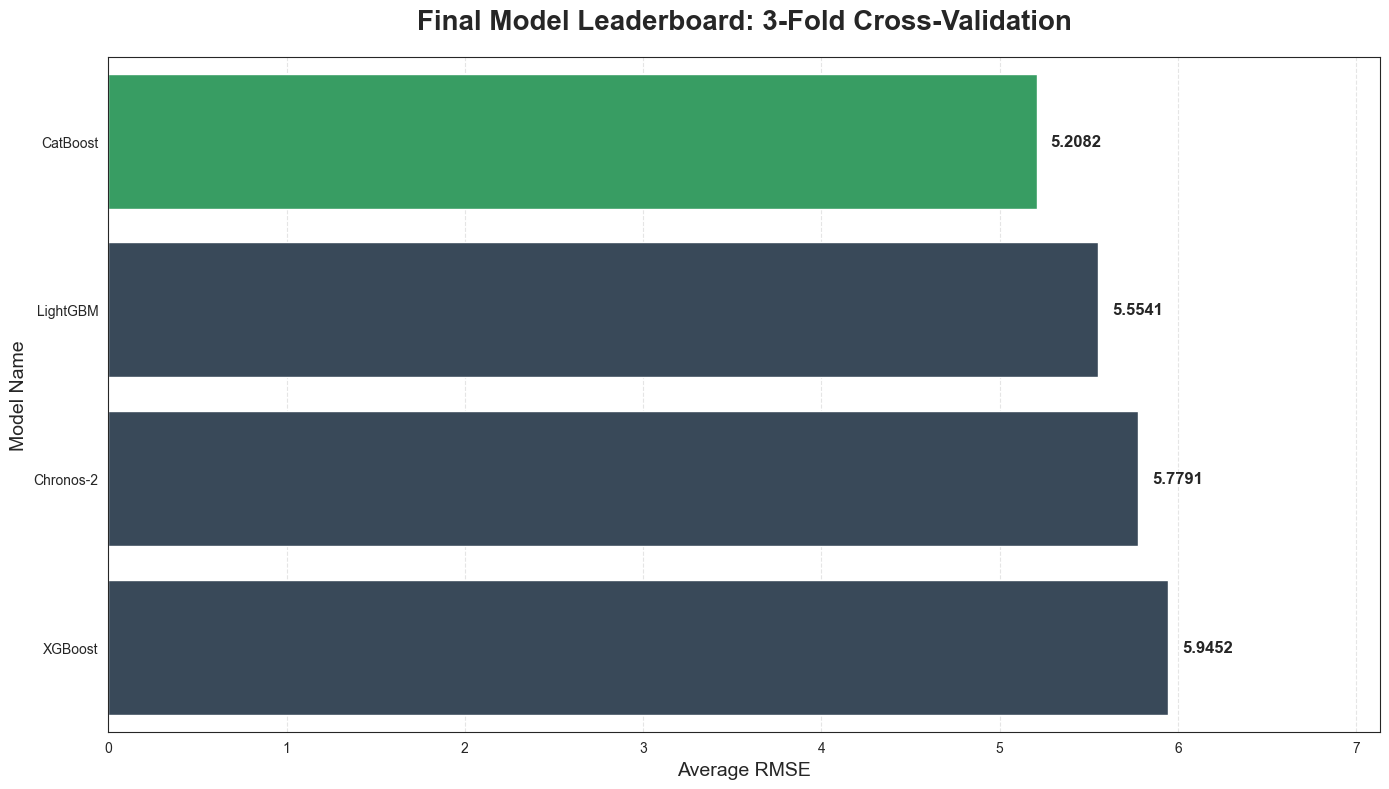

Overall Champion: CatBoost


In [26]:
df_leaderboard = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
df_leaderboard = df_leaderboard.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_leaderboard.iloc[0]['Model']
colors = ['#27ae60' if model == winner_overall else '#34495e' for model in df_leaderboard['Model']]

ax = sns.barplot(
    data=df_leaderboard,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Bar Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Final Model Leaderboard: 3-Fold Cross-Validation', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=14)
plt.ylabel('Model Name', fontsize=14)
plt.xlim(0, df_leaderboard['RMSE'].max() * 1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/model_leaderboard.png')
plt.show()

print(f"Overall Champion: {winner_overall}")

In [27]:
def objective(trial):
    # Suggest the model type first
    model_type = trial.suggest_categorical('model_type', models_to_test)

    # Shared or model-specific parameters
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 8)
    l2_reg = trial.suggest_float('l2_reg', 1e-2, 10.0, log=True)

    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)
    cv_scores = []
    fold_best_ntrees = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_type == 'XGBoost':
            model = xgb.XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500, early_stopping_rounds=30,
                tree_method='hist', enable_categorical=True,
                random_state=42, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            fold_best_ntrees.append(model.best_iteration)

        elif model_type == 'CatBoost':
            model = CatBoostRegressor(
                learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_reg,
                iterations=1500, early_stopping_rounds=30,
                random_seed=42, verbose=False
            )
            model.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))
            fold_best_ntrees.append(model.get_best_iteration())

        elif model_type == 'LightGBM':
            model = lgb.LGBMRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500, random_state=42, verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(30)])
            fold_best_ntrees.append(model.best_iteration_)

        score = root_mean_squared_error(y_va, model.predict(X_va))
        cv_scores.append(score)

        trial.report(np.mean(cv_scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save the best iteration average so we can retrain later
    avg_ntree = int(np.mean(fold_best_ntrees))
    trial.set_user_attr("best_ntree", avg_ntree)

    return np.mean(cv_scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=42),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)

study.optimize(objective, n_trials=100)

print(f"Best Model Type: {study.best_params['model_type']}")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-27 20:10:25,769] A new study created in memory with name: no-name-b181cc19-86c0-4987-9eb2-f2f68e71c0c4
[I 2025-12-27 20:10:27,346] Trial 0 finished with value: 5.157608050624318 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.03968793330444373, 'max_depth': 3, 'l2_reg': 0.029375384576328302}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-27 20:10:28,821] Trial 1 finished with value: 5.198849874213296 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.051059032093947576, 'max_depth': 3, 'l2_reg': 8.123245085588687}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-27 20:10:39,374] Trial 2 finished with value: 5.350410248711455 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.015254

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[344]	valid_0's l2: 25.0541
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:10:40,570] Trial 3 pruned. 


Early stopping, best iteration is:
[210]	valid_0's l2: 11.7471


[I 2025-12-27 20:10:41,279] Trial 4 pruned. 
[I 2025-12-27 20:10:45,044] Trial 5 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[188]	valid_0's l2: 22.9842
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 11.1515
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:10:46,260] Trial 6 finished with value: 5.314856442117631 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.027551959649510765, 'max_depth': 3, 'l2_reg': 0.3058656666978527}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[338]	valid_0's l2: 61.0118


[I 2025-12-27 20:10:47,218] Trial 7 finished with value: 5.465436927943837 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.04597505784732166, 'max_depth': 4, 'l2_reg': 0.3632486956676606}. Best is trial 0 with value: 5.157608050624318.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 27.8635
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:10:47,955] Trial 8 pruned. 


Early stopping, best iteration is:
[47]	valid_0's l2: 11.2629


[I 2025-12-27 20:10:51,090] Trial 9 finished with value: 5.144929382251309 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.015703008378806716, 'max_depth': 3, 'l2_reg': 0.09462175356461491}. Best is trial 9 with value: 5.144929382251309.
[I 2025-12-27 20:10:52,456] Trial 10 pruned. 
[I 2025-12-27 20:10:53,403] Trial 11 finished with value: 5.134028457152339 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.07219519762383077, 'max_depth': 3, 'l2_reg': 0.016347763268654437}. Best is trial 11 with value: 5.134028457152339.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 26.7461
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:10:53,939] Trial 12 pruned. 


Early stopping, best iteration is:
[76]	valid_0's l2: 11.1591


[I 2025-12-27 20:10:57,015] Trial 13 finished with value: 5.12308513190469 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.016847294358735714, 'max_depth': 3, 'l2_reg': 0.06455320174998434}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:10:57,806] Trial 14 finished with value: 5.132841917089759 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.0855597619628387, 'max_depth': 3, 'l2_reg': 0.0417211345942441}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:05,340] Trial 15 finished with value: 5.270748689552341 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.027972348410235576, 'max_depth': 4, 'l2_reg': 0.017759930437607038}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:05,632] Trial 16 pruned. 
[I 2025-12-27 20:11:08,487] Trial 17 finished with value: 5.669707982468107 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.010575309463203335, 'max_depth': 6, 'l2_reg': 0.012188958012648

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 23.0084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[142]	valid_0's l2: 11.1747
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:11:15,319] Trial 22 finished with value: 5.318954902195059 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.05024262448962879, 'max_depth': 3, 'l2_reg': 0.024715302380458645}. Best is trial 13 with value: 5.12308513190469.


Early stopping, best iteration is:
[168]	valid_0's l2: 61.1103


[I 2025-12-27 20:11:16,183] Trial 23 finished with value: 5.604664551764325 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.08061198187898568, 'max_depth': 5, 'l2_reg': 0.014888751331218647}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:16,953] Trial 24 finished with value: 5.1620856259420735 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09816359517941312, 'max_depth': 3, 'l2_reg': 0.03054395531984652}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:17,928] Trial 25 pruned. 
[I 2025-12-27 20:11:28,429] Trial 26 finished with value: 5.524316754035346 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.011161132887403205, 'max_depth': 3, 'l2_reg': 0.021204608552230244}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:31,896] Trial 27 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 23.1611
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's l2: 11.2075
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 60.3905


[I 2025-12-27 20:11:32,398] Trial 28 finished with value: 5.310498498915638 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.08951767990722878, 'max_depth': 3, 'l2_reg': 0.3024034397179338}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:34,366] Trial 29 finished with value: 5.175191891927692 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.028024320671910668, 'max_depth': 3, 'l2_reg': 0.04855858581430192}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:34,873] Trial 30 pruned. 
[I 2025-12-27 20:11:39,112] Trial 31 finished with value: 5.147515641278949 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.01096724688214705, 'max_depth': 3, 'l2_reg': 0.14117039614744353}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:11:41,956] Trial 32 finished with value: 5.182814120748415 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.014933058522387205, 'max_depth': 3, 'l2_reg': 0.074857258015669

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 28.1087
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:11:48,640] Trial 34 pruned. 


Early stopping, best iteration is:
[163]	valid_0's l2: 11.123


[I 2025-12-27 20:11:57,242] Trial 35 pruned. 
[I 2025-12-27 20:11:59,191] Trial 36 finished with value: 5.183875713072054 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.019531992965209632, 'max_depth': 3, 'l2_reg': 0.06453434984505864}. Best is trial 13 with value: 5.12308513190469.
[I 2025-12-27 20:12:00,043] Trial 37 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[339]	valid_0's l2: 22.488
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[482]	valid_0's l2: 11.204
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:02,165] Trial 38 finished with value: 5.313298510622615 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.01455310511249666, 'max_depth': 3, 'l2_reg': 0.05694185968553961}. Best is trial 13 with value: 5.12308513190469.


Early stopping, best iteration is:
[701]	valid_0's l2: 61.6303
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 28.0814
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:02,564] Trial 39 pruned. 


Early stopping, best iteration is:
[34]	valid_0's l2: 11.2689


[I 2025-12-27 20:12:03,500] Trial 40 finished with value: 5.108744605619948 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.08630135507837312, 'max_depth': 3, 'l2_reg': 0.011376726479410546}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:04,608] Trial 41 finished with value: 5.162085861670747 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.062303608738185315, 'max_depth': 3, 'l2_reg': 0.010226468827476454}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:05,434] Trial 42 finished with value: 5.1425886000154115 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09657985039023285, 'max_depth': 3, 'l2_reg': 0.012543257034496762}. Best is trial 40 with value: 5.108744605619948.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's l2: 22.4463
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 11.3298
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:06,137] Trial 43 finished with value: 5.184896935075553 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.09949862036575655, 'max_depth': 3, 'l2_reg': 0.013180946465304624}. Best is trial 40 with value: 5.108744605619948.


Early stopping, best iteration is:
[264]	valid_0's l2: 55.5169


[I 2025-12-27 20:12:06,859] Trial 44 finished with value: 5.22476155132722 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09220647372890906, 'max_depth': 3, 'l2_reg': 0.012007064344514005}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:07,816] Trial 45 finished with value: 5.203006357142417 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.0663154195099804, 'max_depth': 3, 'l2_reg': 0.11198877222740244}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:08,642] Trial 46 finished with value: 5.1587794537640095 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.0992922130900836, 'max_depth': 3, 'l2_reg': 0.013483230553846285}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:09,714] Trial 47 finished with value: 5.4200801344514495 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.056421617177967516, 'max_depth': 4, 'l2_reg': 0.010378673732457688}. Best is trial 40 with value: 5.108744

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[276]	valid_0's l2: 29.2559
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:13,226] Trial 49 pruned. 


Early stopping, best iteration is:
[270]	valid_0's l2: 10.8823
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[296]	valid_0's l2: 22.7962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[191]	valid_0's l2: 11.6405
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:14,768] Trial 50 finished with value: 5.313169373119755 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.02026446830830357, 'max_depth': 3, 'l2_reg': 8.692599023656625}. Best is trial 40 with value: 5.108744605619948.


Early stopping, best iteration is:
[583]	valid_0's l2: 60.1115


[I 2025-12-27 20:12:16,351] Trial 51 finished with value: 5.938296667200448 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.07287856591745573, 'max_depth': 7, 'l2_reg': 8.439656364876337}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:27,678] Trial 52 finished with value: 5.462007451910453 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.01572516272394315, 'max_depth': 3, 'l2_reg': 0.22538703119321646}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:30,493] Trial 53 finished with value: 5.1684096656422165 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.01753697387102617, 'max_depth': 3, 'l2_reg': 0.3973075062663489}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:31,351] Trial 54 finished with value: 5.165091218862988 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.07479346463920573, 'max_depth': 3, 'l2_reg': 0.04906966709127841}. Best is trial 40 with value: 5.1087446056

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[253]	valid_0's l2: 27.9188
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:33,656] Trial 55 pruned. 


Early stopping, best iteration is:
[259]	valid_0's l2: 11.1317


[I 2025-12-27 20:12:36,428] Trial 56 finished with value: 5.399316889437813 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.059879766322439035, 'max_depth': 4, 'l2_reg': 0.02926227249713846}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:40,033] Trial 57 finished with value: 5.162910935861684 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.014709962103353362, 'max_depth': 3, 'l2_reg': 0.025007115386779303}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:40,902] Trial 58 finished with value: 5.208836106620222 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.058604462228761776, 'max_depth': 3, 'l2_reg': 0.030464191445438393}. Best is trial 40 with value: 5.108744605619948.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 27.911
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:41,629] Trial 59 pruned. 


Early stopping, best iteration is:
[62]	valid_0's l2: 10.9966


[I 2025-12-27 20:12:42,512] Trial 60 finished with value: 5.141107930288061 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09640398944010631, 'max_depth': 3, 'l2_reg': 0.02559088047589679}. Best is trial 40 with value: 5.108744605619948.
[I 2025-12-27 20:12:43,458] Trial 61 finished with value: 5.06934554320815 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.07718131991003502, 'max_depth': 3, 'l2_reg': 0.04394767664278768}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:12:44,445] Trial 62 finished with value: 5.176715172817903 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.07308268762655082, 'max_depth': 3, 'l2_reg': 0.042614552716985124}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:12:45,077] Trial 63 finished with value: 5.187945883003576 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09110698461629839, 'max_depth': 3, 'l2_reg': 0.04264920993391409}. Best is trial 61 with value: 5.06934554320

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 25.2646
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[137]	valid_0's l2: 11.4559
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:12:53,547] Trial 68 finished with value: 5.497603576729484 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.07112512869486343, 'max_depth': 4, 'l2_reg': 0.04992172851704285}. Best is trial 61 with value: 5.06934554320815.


Early stopping, best iteration is:
[161]	valid_0's l2: 65.3149


[I 2025-12-27 20:12:57,668] Trial 69 finished with value: 5.433771762939949 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.06183956423469572, 'max_depth': 3, 'l2_reg': 0.015281401386239667}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:03,197] Trial 70 finished with value: 5.930895210201133 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.01211087009880448, 'max_depth': 8, 'l2_reg': 0.1485108271795801}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:04,033] Trial 71 pruned. 
[I 2025-12-27 20:13:04,409] Trial 72 pruned. 
[I 2025-12-27 20:13:06,442] Trial 73 pruned. 
[I 2025-12-27 20:13:23,387] Trial 74 finished with value: 5.34763148999063 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.013651577463590601, 'max_depth': 5, 'l2_reg': 6.126768414730328}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:24,411] Trial 75 finished with value: 5.123469434072429 and parameters: {'model_type': 'X

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 23.0754
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 11.228
Training until validation scores don't improve for 30 rounds


[I 2025-12-27 20:13:32,151] Trial 85 finished with value: 5.230898496697431 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.06349451274001239, 'max_depth': 3, 'l2_reg': 0.016014529650979086}. Best is trial 61 with value: 5.06934554320815.


Early stopping, best iteration is:
[431]	valid_0's l2: 56.8243


[I 2025-12-27 20:13:34,052] Trial 86 pruned. 
[I 2025-12-27 20:13:42,267] Trial 87 finished with value: 5.334925376583364 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.02370206112162784, 'max_depth': 6, 'l2_reg': 0.4869735027350121}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:42,977] Trial 88 finished with value: 5.174013270156811 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09689927105795308, 'max_depth': 3, 'l2_reg': 0.029803382726270356}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:43,464] Trial 89 pruned. 
[I 2025-12-27 20:13:44,790] Trial 90 pruned. 
[I 2025-12-27 20:13:45,710] Trial 91 finished with value: 5.113274864588928 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.08193847083593067, 'max_depth': 3, 'l2_reg': 0.010401246946761063}. Best is trial 61 with value: 5.06934554320815.
[I 2025-12-27 20:13:46,713] Trial 92 finished with value: 5.186277484516949 and parameters: {'model_type': 

Best Model Type: XGBoost
Best RMSE: 5.0693
Best Hyperparameters: {'model_type': 'XGBoost', 'learning_rate': 0.07718131991003502, 'max_depth': 3, 'l2_reg': 0.04394767664278768}


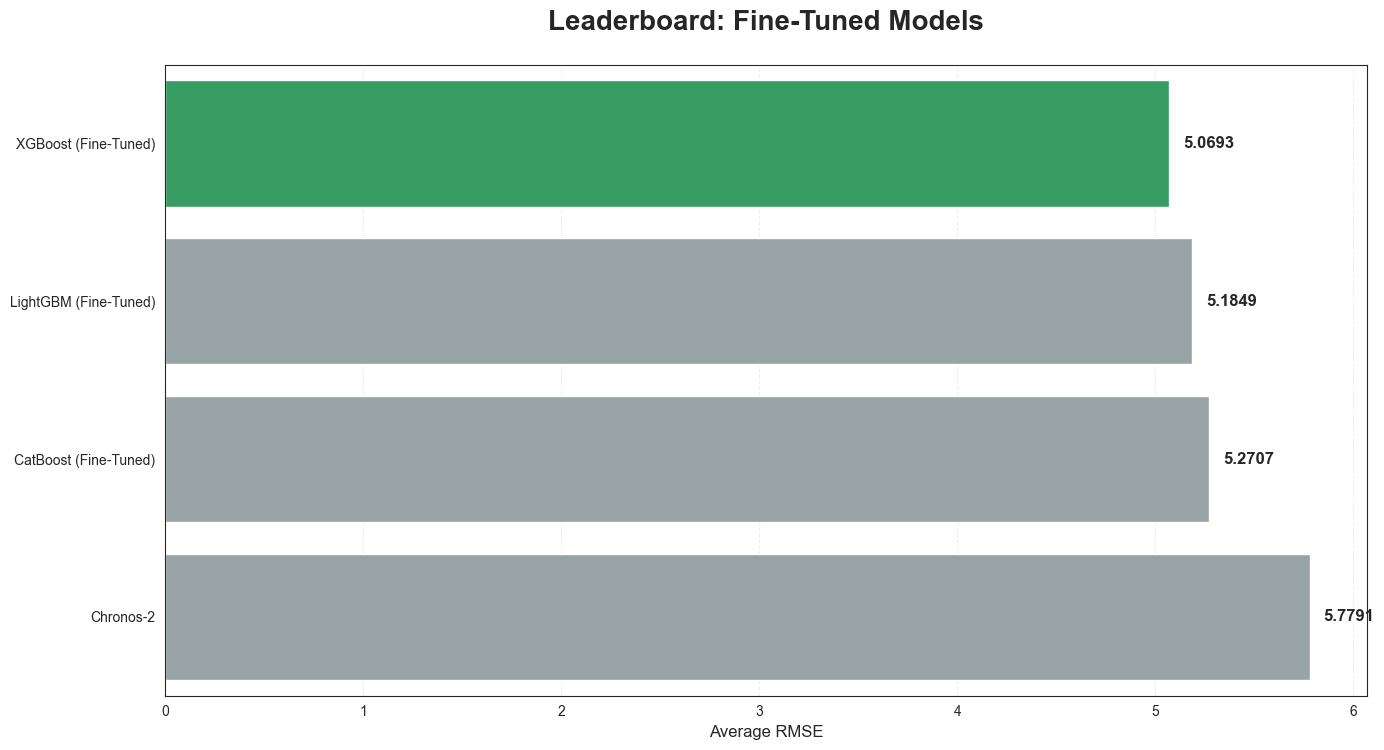

In [28]:
final_leaderboard_data = []

for model_name, baseline_rmse in results.items():
    if model_name in models_to_test:
        # Get all successful trials for this specific model type
        model_trials = [
            t.value for t in study.trials
            if t.state == optuna.trial.TrialState.COMPLETE
            and t.params.get('model_type') == model_name
        ]

        if model_trials:
            best_tuned_rmse = min(model_trials)
            # Add with a marker
            final_leaderboard_data.append({
                'Model': f"{model_name} (Fine-Tuned)",
                'RMSE': best_tuned_rmse,
                'Is_Tuned': True
            })
        else:
            # If for some reason no trial succeeded, keep baseline
            final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})
    else:
        # For non-tuned models (like Chronos 2)
        final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})

# Create and sort the DataFrame
df_final = pd.DataFrame(final_leaderboard_data).sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_final.iloc[0]['Model']

colors = []
for _, row in df_final.iterrows():
    if row['Model'] == winner_overall:
        colors.append('#27ae60')
    else:
        colors.append('#95a5a6')

ax = sns.barplot(
    data=df_final,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Leaderboard: Fine-Tuned Models', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('images/model_leaderboard_fine_tuned.png')
plt.show()

In [29]:
# Extract best values
best_params = study.best_params.copy()
best_ntree = study.best_trial.user_attrs["best_ntree"]

fine_tuned_winner = best_params.pop('model_type')
print(f"Best Model Type: {fine_tuned_winner}")

# Handle parameter name mapping (L2 Regularization)
l2_val = best_params.pop('l2_reg', None)

if fine_tuned_winner == 'XGBoost':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = xgb.XGBRegressor(
        **best_params,
        n_estimators=best_ntree,
        tree_method='hist',
        enable_categorical=True,
        random_state=42
    )

elif fine_tuned_winner == 'CatBoost':
    if l2_val is not None: best_params['l2_leaf_reg'] = l2_val
    final_model = CatBoostRegressor(
        **best_params,
        iterations=best_ntree,
        random_seed=42,
        verbose=False,
        cat_features=categorical_features
    )

elif fine_tuned_winner == 'LightGBM':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = lgb.LGBMRegressor(
        **best_params,
        n_estimators=best_ntree,
        random_state=42,
        verbose=-1
    )

# Final Fit
final_model.fit(X_train_full, y_train_full)

print(f"Winner: {winner_overall}")
print(f"Best iteration count: {best_ntree}")

Best Model Type: XGBoost
Winner: XGBoost (Fine-Tuned)
Best iteration count: 139


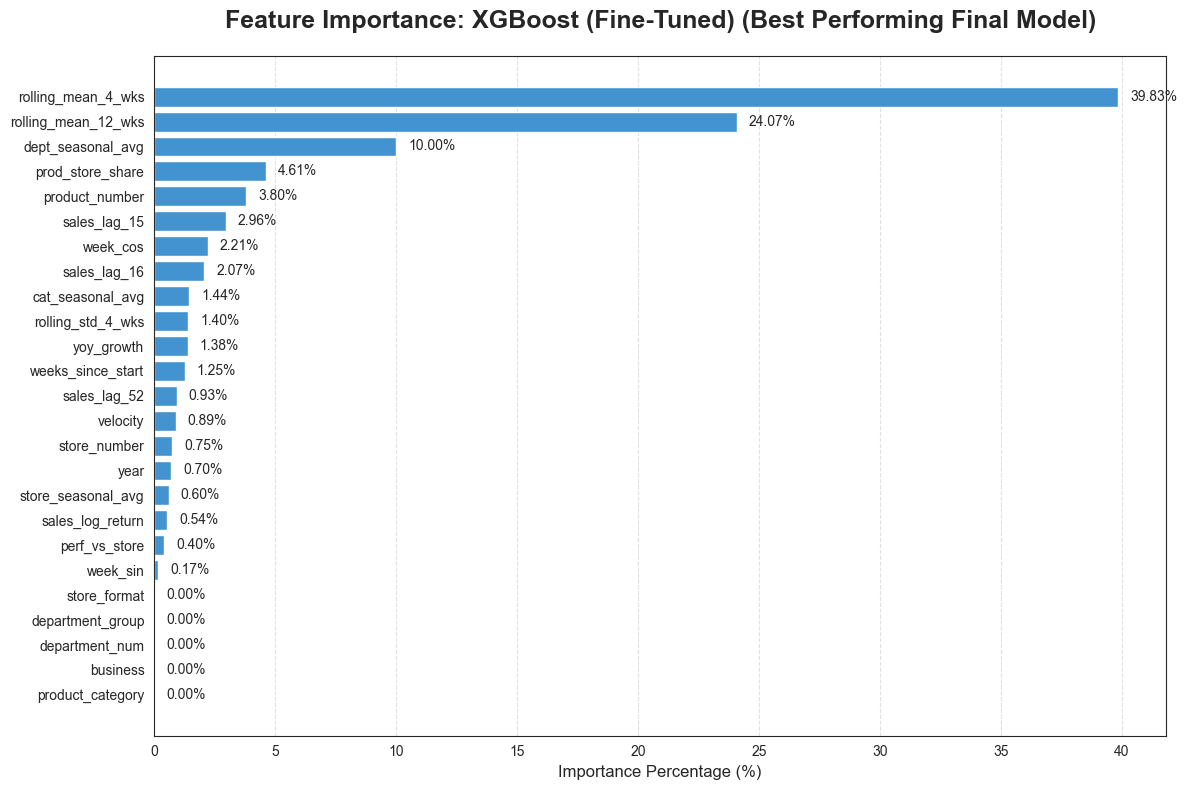

In [30]:
feature_names = X_train_full.columns

if fine_tuned_winner == 'CatBoost':
    importances = final_model.get_feature_importance()
    color = '#27ae60'
elif fine_tuned_winner == 'XGBoost':
    importances = final_model.feature_importances_
    color = '#2980b9'
elif fine_tuned_winner == 'LightGBM':
    importances = final_model.feature_importances_
    color = '#f39c12'

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Normalize importances of the features
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="#4293D0")

plt.title(f'Feature Importance: {winner_overall} (Best Performing Final Model)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Importance Percentage (%)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
save_path = f"images/feature_importance_{winner_overall}.png"
plt.savefig(save_path)
plt.show()

## Test Data

In [31]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_train_full.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if winner_overall != 'CatBoost':
    for col in categorical_features:
        # 1. Ensure the column exists in test
        if col in X_test_predict.columns:
            # 2. Force the test column to match the training column's category dtype exactly
            X_test_predict[col] = X_test_predict[col].astype(X_train_full[col].dtype)

            # 3. Handle any potential "unseen" categories in the test set by setting them to NaN
            # (XGBoost handles NaNs in categories automatically)
            X_test_predict[col] = X_test_predict[col].where(
                X_test_predict[col].isin(X_train_full[col].cat.categories)
            )

# Verify no column-order mismatch (XGBoost requires columns in same order as training)
X_test_predict = X_test_predict[X_train_full.columns]

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'week']].copy()
df_results['sales'] = test_predictions

df_results_preprocessed = data_loader.preprocessing(df_results)

output_path = f'results/final_sales_predictions_{winner_overall}.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

Predictions saved to results/final_sales_predictions_XGBoost (Fine-Tuned).xlsx
     store_number  product_number       week     sales
142             0             126 2024-12-30  2.400572
143             0             126 2025-01-06  1.341650
144             0             126 2025-01-13  1.760096
145             0             126 2025-01-20  1.821802
146             0             126 2025-01-27  2.323611


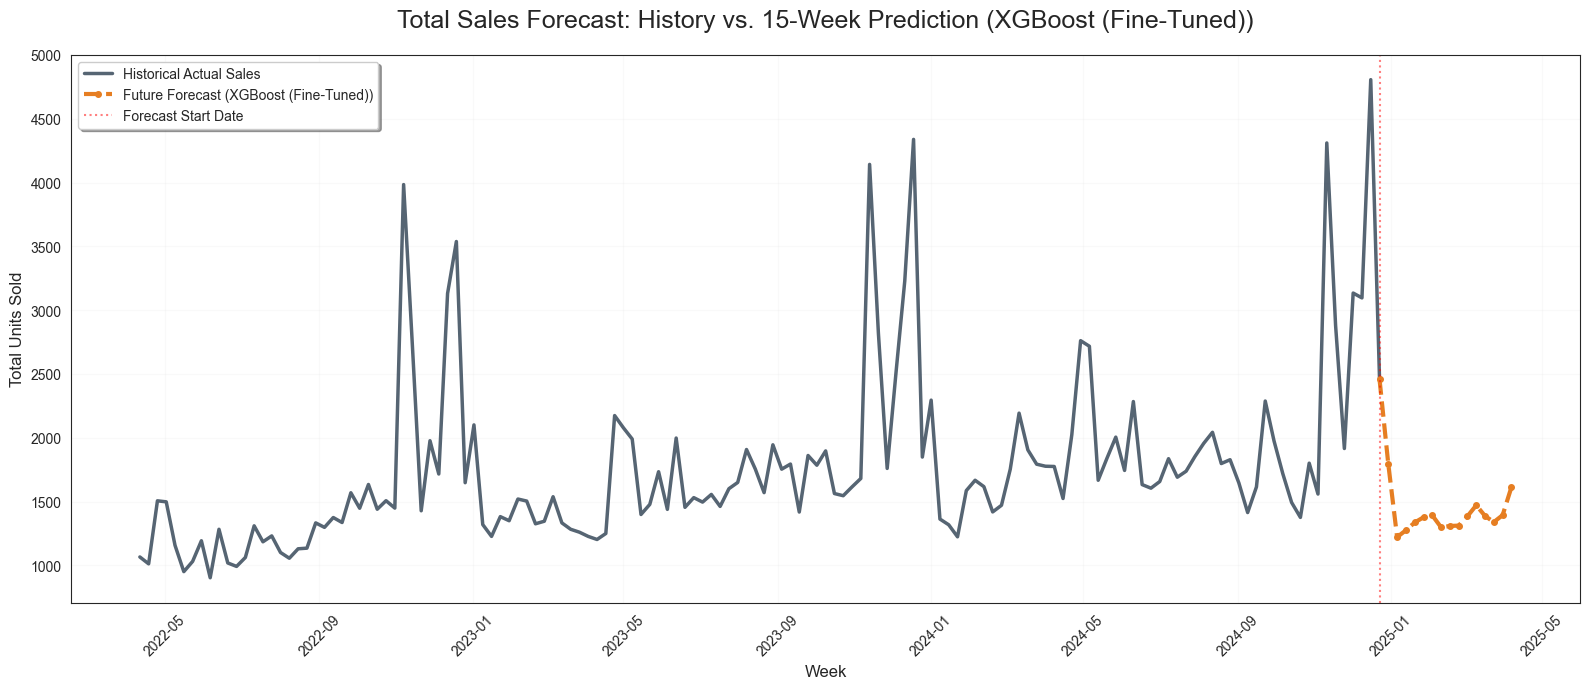

In [32]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_train_full.index],
    'sales': y_train_full
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1).rename(columns={'sales': 'sales'})

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(16, 7))

# Plot Historical Sales
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#2c3e50', linewidth=2.5, alpha=0.8)

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['sales'],
         label=f'Future Forecast ({winner_overall})', color='#e67e22',
         linestyle='--', linewidth=3, marker='o', markersize=4)

# Split Line
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({winner_overall})", fontsize=18, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='-', alpha=0.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('images/sales_forecast_connected.png')
plt.show()

## Trends in Forecast Data

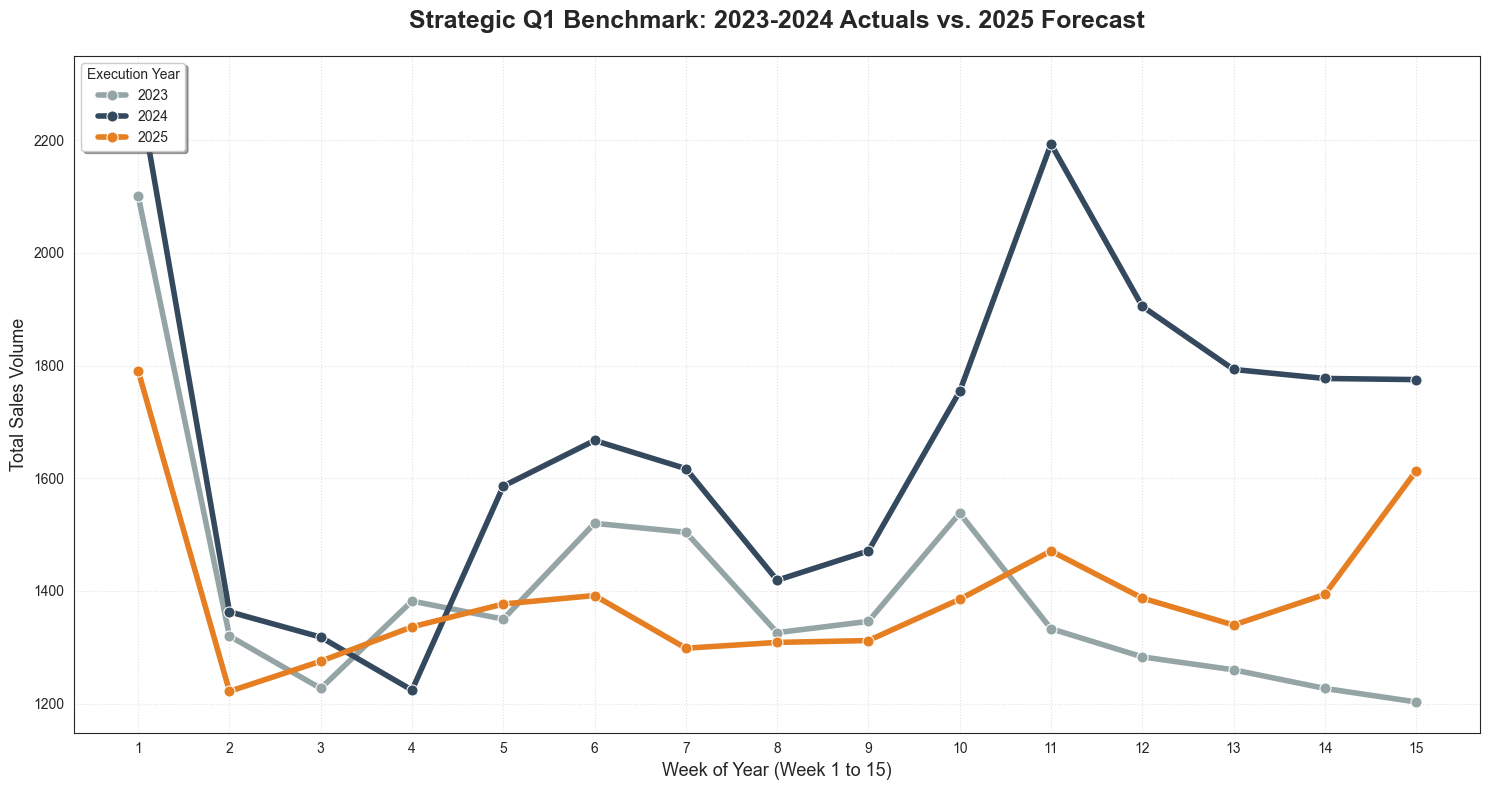

In [33]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('Strategic Q1 Benchmark: 2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig("images/benchmark_yoy.png")
plt.show()

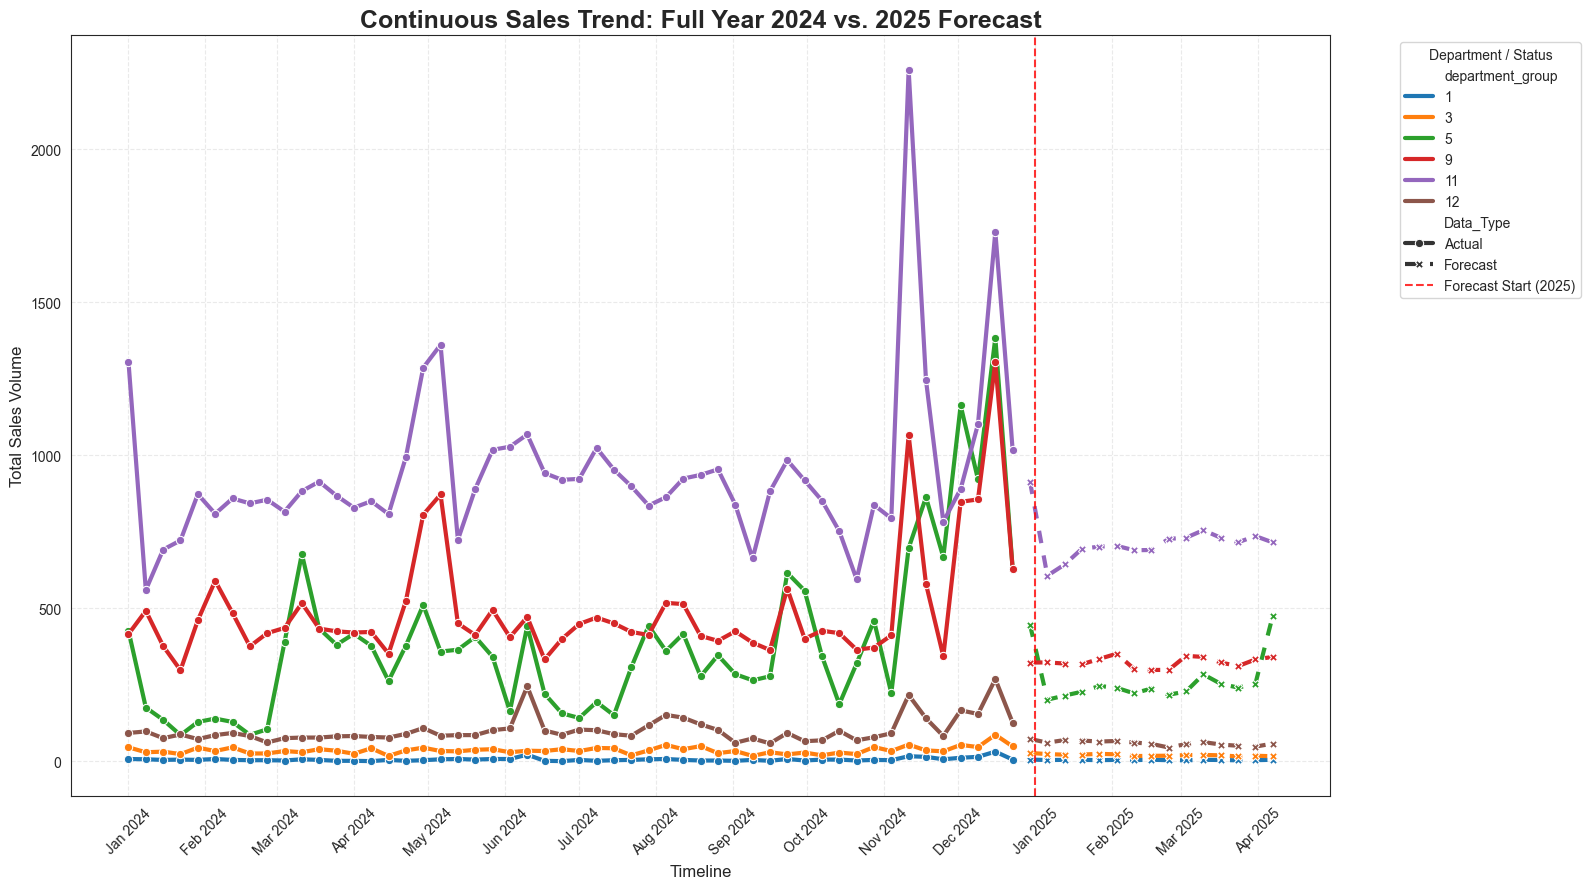

In [34]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(16, 9))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/sales_trend_per_department.png")
plt.show()